In [ ]:
# Copyright (C) 2024  Jose Ángel Pérez Garrido
# 
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

## Problem description
In this notebook we will develop several convolutional neural network (CNNs) models trying to predict an animal given its image.

## Dataset description
We will use the ["Animals dataset"](https://www.kaggle.com/datasets/antobenedetti/animals/data) that contains about 15K pictures of five types of animals: cats, dogs, elephants, horses & lions, collected from Google Images.

### Configure the environment
Set the following variables with your specific configuration:

In [1]:
# Set Random Seed to ensure reproducibility of the experiments
RANDOM_SEED = 54

# Directory parameters
DATASET_PATH = './datasets/animals'
OUT_MODELS_FOLDER = "./output"

# Image parameters
# Rescaling
IMG_HEIGHT = 180
IMG_WIDTH = 180

# Model parameters
BATCH_SIZE = 32

### Prepare the environment

In [2]:
import os

import keras
from keras import utils, layers, optimizers, applications

import keras_tuner

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from tabulate import tabulate

from itertools import product

# AUXILIARY FUNCTIONS
def plot(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, "b-o", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "r-o", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, "b-o", label="Training loss")
    plt.plot(epochs, val_loss, "r-o", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

def plot_distribution(dataset):
    ax = sns.countplot(dataset.label)
    plt.xticks(ticks=labels, labels = product)
    plt.title('Distribution of Target Classes, Train', fontsize=18, y=1.02)
    # Loops through each bar in the plot and adds an annotation with the height of the bar
    for bar in ax.patches:
        ax.annotate(format(bar.get_height(), '.0f'),(bar.get_x() + bar.get_width() / 2,bar.get_height()), 
                    ha='center', va='center',size=15, xytext=(0, 8),textcoords='offset points')
    plt.show()

def plot_results(model_names, metric_name, validation_results, test_results):
    # Set width of bar
    bar_width = 0.35

    # Set position of bar on X axis
    r1 = np.arange(len(validation_results))
    r2 = [x + bar_width for x in r1]

    # Make the plot
    plt.bar(r1, validation_results, color='b', width=bar_width, edgecolor='grey', label='Validation '+metric_name)
    plt.bar(r2, test_results, color='r', width=bar_width, edgecolor='grey', label='Test '+metric_name)

    # Add xticks on the middle of the group bars
    plt.xlabel('Models', fontweight='bold')
    plt.xticks([r + bar_width/2 for r in range(len(validation_results))], model_names)

    # Add ylabel
    plt.ylabel(metric_name, fontweight='bold')

    # Add title
    plt.title('Validation and Test '+metric_name+' for Different Models')

    # Add legend
    plt.legend()

    # Show plot
    plt.show()

2024-03-05 18:47:31.839478: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 18:47:31.839533: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 18:47:31.888113: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 18:47:31.991727: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 18:47:32.967677: W tensorflow/compiler/tf2

## 1. Preprocess the dataset

This step will load and prepare the dataset for training and evaluation.

Some comments about the dataset:
- The dataset is already divided into train and validation subsets. The val part of the dataset will be left as a test set
- The train subset will be further subdivided, leaving 10% of the data for validation.
- Each image is standarized to a more manageable size 180x180x3 tensor (RGB).
- Images are normalized between [0, 1] to facilitate the learning process of the networks.
- Each label consists in a number asociated to a kind of animal (cat, dog, elephant, horse and lion).
- In each batch iteration, 32 (BATCH_SIZE) images are seen.
- Training, validation and test sets will be a (`tf.data.Dataset`)

In [3]:
# Set the path for the dataset
assert os.path.exists(DATASET_PATH), f'Verify the dataset is located at {DATASET_PATH}'

def normalization(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

# Load train, validation and test datasets
train_dataset, val_dataset = utils.image_dataset_from_directory(DATASET_PATH+"/train",                             
                                                   image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                   label_mode="categorical",
                                                   batch_size=BATCH_SIZE,
                                                   seed=RANDOM_SEED,
                                                   subset="both", # Return both training and validation sets
                                                   validation_split=0.1)
test_dataset = utils.image_dataset_from_directory(DATASET_PATH+"/val", # val folder will be left as a test set in order to compare the generalization capability of the different models.
                                                  image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                   label_mode="categorical",
                                                   batch_size=BATCH_SIZE,
                                                   seed=RANDOM_SEED)

# Normalization
train_dataset = train_dataset.map(normalization)
val_dataset = val_dataset.map(normalization)
test_dataset = test_dataset.map(normalization)

Found 13474 files belonging to 5 classes.
Using 12127 files for training.
Using 1347 files for validation.


2024-03-05 18:47:51.554880: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-05 18:47:51.721749: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-05 18:47:51.721998: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-05 18:47:51.725028: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-05 18:47:51.725247: I external/local_xla/xla/stream_executor

Found 1497 files belonging to 5 classes.


Image shape:  (180, 180, 3)
Label:  [0. 0. 0. 0. 1.]


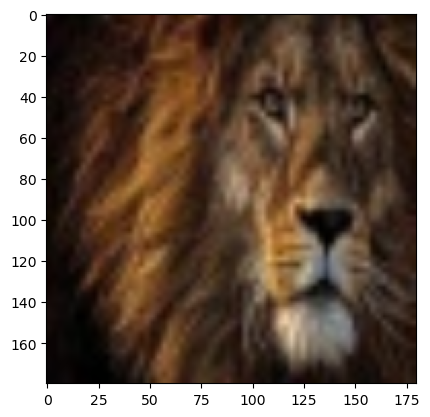

Image shape:  (180, 180, 3)
Label:  [0. 0. 0. 1. 0.]


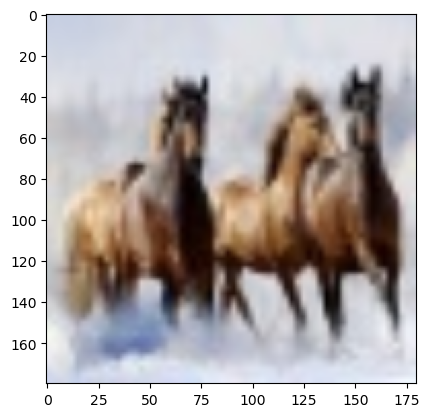

Image shape:  (180, 180, 3)
Label:  [0. 1. 0. 0. 0.]


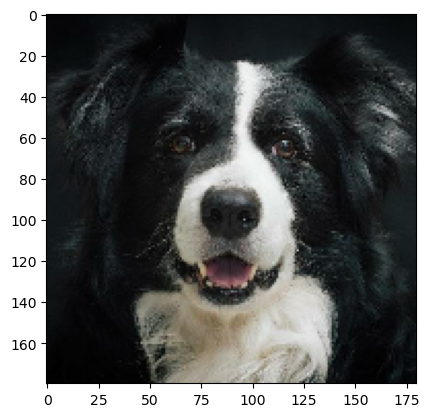

Image shape:  (180, 180, 3)
Label:  [0. 0. 1. 0. 0.]


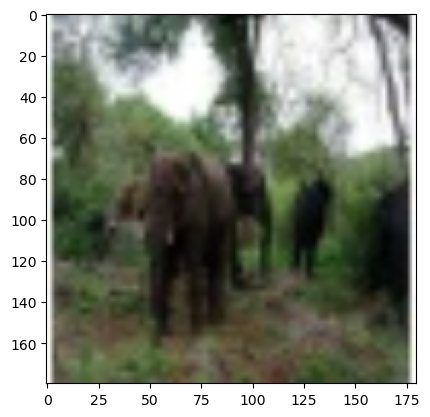

Image shape:  (180, 180, 3)
Label:  [0. 0. 0. 1. 0.]


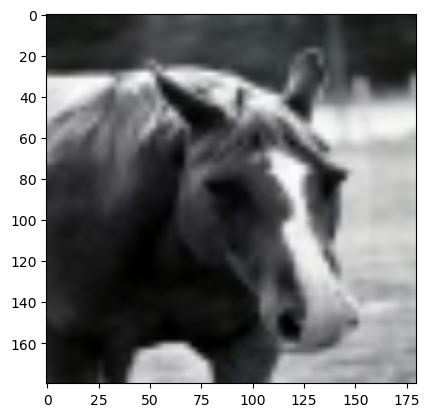

In [7]:
# Visualize sample images
for batch_images, batch_labels in train_dataset.take(5):
    print("Image shape: ", batch_images[0].numpy().shape)
    print("Label: ", batch_labels[0].numpy())
    plt.imshow(batch_images[0].numpy())
    plt.show()

## 2. Develop a custom convolutional model for the classification problem.
The network considered for this lab session is a **Convolutional Neural Network (CNN)**, well-suited models for a wide range of image classification tasks due to multiple factors:

- **Local connectivity**: the operation of the convolution with filters of a smaller size than the input means that the connectivity is local, which reduces the number of operations by performing computations only in subregions and not having connections to all the input, as in fully connected networks. In addition, it allows each neuron to specialize in a different feature, allowing complex interactions to be modeled as a function of the activations of different neurons.

- **Shared weights**: all neurons operating on the same feature map employ filters with the same coefficients (same kernel), further reducing the total number of parameters. Without this property, the filter coefficients at each point during the convolution process would vary. Intuitively, in the case of an image, it is understood that, for example, if a filter is useful for detecting edges at a certain position, it is also useful for detecting edges at any other position of the image.

- **Translation invariance**: shared weights cause the data representations to be moved in the feature map when the input is also moved.

- **Spatial hierarchies of patterns**: the network learns how to represent the input information from the lowest level up through multiple layers to create increasingly sophisticated representations of the data. For example, the layers closest to the input are responsible for learning what an edge or a corner is, while later layers receive the information from these neurons and combine them to decide that if there are two vertical and horizontal edges in close proximity, parallel two by two, then you are dealing with a rectangle. This feature allows reusing networks that were trained on one dataset to apply them in other domains by changing only the deepest layers, which are specialized in the training domain.

- **No need for feature engineering**: filters are automatically learnt during the training process, so we do not need to hand-craft features in order to train efficiently the network. In fact, it is the same network the one that decides which features are most important by adapting its filters to the current problem.


The basic architecture for our initial experiments is composed of **Blocks of convolution and max-pooling (feature extraction block), followed by dense layers (classification block)**. A flatten layer is also needed between the feature extraction blocks and the classification block because the latter only accepts a vector as input, not matrices nor tensors.

In order to determine the best architecture of the model (convolutional layers, pooling layers, number of filters, size of kernels, etc.) several experiments are carried out below to find the architecture which best fits to out classification problem. Once the best architecture is obtained, we will check if there is a problem of **overfitting** and, if so, will apply regularization techniques to check if the performance of the network is affected.

**Accuracy** will be the metric in use to evaluate the performance of the trained classifiers. As it reflects the overall correctness of the model across all classes, it is particularly suitable since classes in the Animals dataset are balanced, meaning they have roughly the same number of samples (≈2700 instances per class). F1-score, as well as Precision and Recall, are also computed for comparative purposes.

Note that the most relevant trained models will be saved into `./output` folder making possible a later analysis.

First, let's see whether CNNs can provide fair results with a single test experiment.

In [ ]:
# First hand-crafted experiment
inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Feature extraction block
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu")(inputs)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu")(x)
x = layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Classification block
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)

# Output layer
outputs = layers.Dense(5, activation="softmax")(x)

# Prepare model
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 88, 88, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                             

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=OUT_MODELS_FOLDER+"/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

model.compile(optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy",keras.metrics.F1Score(),keras.metrics.Precision(),keras.metrics.Recall()])

history = model.fit(train_dataset, epochs=25, batch_size=BATCH_SIZE,
          validation_data=val_dataset,
          callbacks=callbacks)

Epoch 1/25


2024-02-18 18:18:12.737855: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-18 18:18:13.574700: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-18 18:18:15.424864: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9ec4017140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-18 18:18:15.424898: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-02-18 18:18:15.436865: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708276695.539743    7485 device_compiler.h:186] Compiled cluster using XLA!  T

379/379 [==============================] - 57s 115ms/step - loss: 1.3022 - accuracy: 0.4732 - f1_score: 0.4696 - precision: 0.7294 - recall: 0.2268 - val_loss: 0.8808 - val_accuracy: 0.6696 - val_f1_score: 0.6662 - val_precision: 0.8268 - val_recall: 0.4217
Epoch 2/25
379/379 [==============================] - 37s 96ms/step - loss: 0.7431 - accuracy: 0.7043 - f1_score: 0.7038 - precision: 0.7980 - recall: 0.5762 - val_loss: 0.6680 - val_accuracy: 0.7402 - val_f1_score: 0.7395 - val_precision: 0.8300 - val_recall: 0.5909
Epoch 3/25
379/379 [==============================] - 37s 97ms/step - loss: 0.5367 - accuracy: 0.7878 - f1_score: 0.7877 - precision: 0.8397 - recall: 0.7268 - val_loss: 0.5879 - val_accuracy: 0.7721 - val_f1_score: 0.7735 - val_precision: 0.8054 - val_recall: 0.7342
Epoch 4/25
379/379 [==============================] - 26s 68ms/step - loss: 0.3771 - accuracy: 0.8512 - f1_score: 0.8512 - precision: 0.8831 - recall: 0.8173 - val_loss: 0.6857 - val_accuracy: 0.7595 - val_

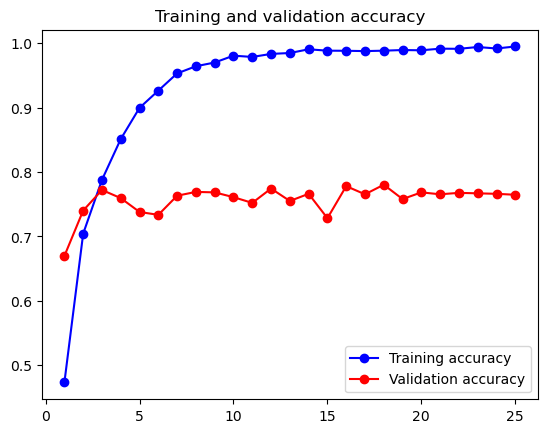

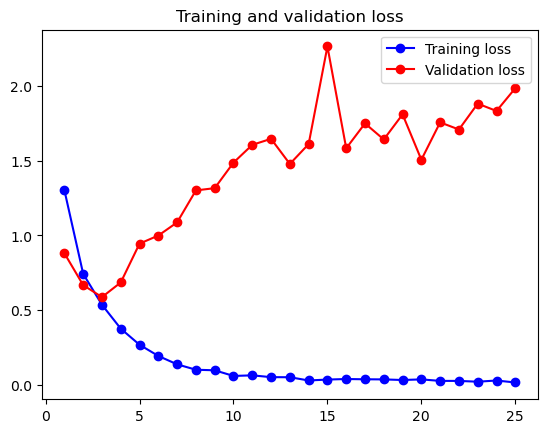

In [6]:
plot(history)

### Architecture tuning
The previous results show that this basic architecture could be suitable for this problem, reaching a good test accuracy (0.81). In order to maximize the network's performance, in this section 15 different variations following a Random Search approach are tested using [KerasTuner](https://keras.io/keras_tuner/), a general-purpose hyperparameter tuning library. The different parameters tested on the network are detailed below:
- **Depth of the first convolutional layer** (input_units): For successives convolutional layers, depth is doubled while the resolutions are halved. Parameters tested: [32, 64]
- **Kernel size of the convolutional layers** (kernel_size). Parameters tested: [3, 5, 7, 9]
- **Blocks of convolution and max-pooling** (n_layers). Parameters tested: [1, 2, 3]
- **Number of convolutional layers followed by a max-pooling layer** (n_conv). Parameters tested: [1, 2, 3]
- **Number of dense layers in the classification block** (n_connections). Parameters tested: [1, 2, 3, 4]
- **Number of units in a dense layer** (n_nodes). Parameters tested: [128, 256, 512, 1024]

In [17]:
def test_architecture(hp):  # random search passes this hyperparameter() object 
    # Get hyperparameters
    input_filters = hp.Int('input_units',min_value=32, max_value=64, step=32)
    kernel_size = hp.Int('kernel_size',min_value=3, max_value=9, step=2)
    
    # Feature extraction block
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    # Convolution layer
    x = layers.Conv2D(filters=input_filters, kernel_size=kernel_size, activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # (Adjustable) More convolution layers and convolution per pooling
    for i in range(hp.Int('n_layers', 1, 3)):  # adding variation of layers.
        for j in range(hp.Int('n_conv', 1, 3)):  # adding variation of conv per pooling.
            x = layers.Conv2D(filters=(input_filters*(2**i)), # increase depth by power of 2 for each conv layer
                               kernel_size=kernel_size, activation="relu")(x)
        
        x = layers.MaxPooling2D(pool_size=2)(x)

    # Flatten layer
    x = layers.Flatten()(x)

    ##################################################
    # Classification block
    # Fully connected layers
    for i in range(hp.Int('n_connections', 1, 4)):
        x = layers.Dense(hp.Choice(f'n_nodes',
                                  values=[128, 256, 512, 1024]), activation="relu")(x)
    
    # Output layer
    outputs = layers.Dense(5, activation="softmax")(x)

    # Prepare model
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy",keras.metrics.F1Score(),keras.metrics.Precision(),keras.metrics.Recall()]
    )

    return model

In [18]:
# Generate tuner
tuner = keras_tuner.RandomSearch(
    hypermodel=test_architecture,
    objective="val_accuracy",
    max_trials=15,
    overwrite=True,
    directory=OUT_MODELS_FOLDER,
    project_name="define_arch",
    seed=RANDOM_SEED
)

tuner.search_space_summary()

Search space summary
Default search space size: 6
input_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 32, 'sampling': 'linear'}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 9, 'step': 2, 'sampling': 'linear'}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
n_conv (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
n_connections (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
n_nodes (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512, 1024], 'ordered': True}


In [20]:
# Search the best architecture
tuner.search(train_dataset, epochs=25, validation_data=val_dataset,
        callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", patience=2)])

Trial 15 Complete [00h 00m 47s]
val_accuracy: 0.7988121509552002

Best val_accuracy So Far: 0.8381588459014893
Total elapsed time: 00h 09m 45s


In [21]:
# Get the top model
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856 

As we can see, the best architecture provides a val_accuracy of **0.84**, a really good start. In the following cells we can see a summary of the tuning results.

In [22]:
# Print a summary of the search results.
tuner.results_summary()

Results summary
Results in ./output/define_arch
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
input_units: 64
kernel_size: 3
n_layers: 3
n_conv: 1
n_connections: 3
n_nodes: 128
Score: 0.8381588459014893

Trial 05 summary
Hyperparameters:
input_units: 64
kernel_size: 3
n_layers: 3
n_conv: 1
n_connections: 2
n_nodes: 128
Score: 0.8195990920066833

Trial 07 summary
Hyperparameters:
input_units: 32
kernel_size: 3
n_layers: 2
n_conv: 2
n_connections: 1
n_nodes: 512
Score: 0.8129175901412964

Trial 14 summary
Hyperparameters:
input_units: 32
kernel_size: 3
n_layers: 3
n_conv: 2
n_connections: 3
n_nodes: 1024
Score: 0.7988121509552002

Trial 11 summary
Hyperparameters:
input_units: 64
kernel_size: 3
n_layers: 2
n_conv: 1
n_connections: 4
n_nodes: 1024
Score: 0.7869338989257812

Trial 12 summary
Hyperparameters:
input_units: 64
kernel_size: 3
n_layers: 3
n_conv: 2
n_connections: 3
n_nodes: 256
Score: 0.7824795842170715

Trial 04 summa

In [23]:
# Show best architecture found
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

{'input_units': 64, 'kernel_size': 3, 'n_layers': 3, 'n_conv': 1, 'n_connections': 3, 'n_nodes': 128}


### ARCHITECTURE 1
### Train the best model

Using the previous architecture:
- **Depth of the first convolutional layer** (input_units): 64
- **Kernel size of the convolutional layers** (kernel_size): 3
- **Blocks of convolution and max-pooling** (n_layers): 3
- **Number of convolutional layers followed by a max-pooling layer** (n_conv): 1
- **Number of dense layers in the classification block** (n_connections): 3
- **Number of units in a dense layer** (n_nodes): 128

we will perform a full training without `EarlyStopping` to more clearly see the effects of possible overfitting and whether our model needs regularization.

In [24]:
# Build the model with the best hyperparameters.
model = test_architecture(best_hps)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=OUT_MODELS_FOLDER+"/cnn_best_architecture.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/25
379/379 [==============================] - 8s 17ms/step - loss: 1.0257 - accuracy: 0.5602 - f1_score: 0.5615 - precision_1: 0.7519 - recall_1: 0.3681 - val_loss: 0.6426 - val_accuracy: 0.7342 - val_f1_score: 0.7306 - val_precision_1: 0.7894 - val_recall_1: 0.6622
Epoch 2/25
379/379 [==============================] - 7s 17ms/step - loss: 0.5982 - accuracy: 0.7595 - f1_score: 0.7588 - precision_1: 0.8138 - recall_1: 0.6940 - val_loss: 0.5558 - val_accuracy: 0.7803 - val_f1_score: 0.7798 - val_precision_1: 0.8295 - val_recall_1: 0.7298
Epoch 3/25
379/379 [==============================] - 6s 16ms/step - loss: 0.4969 - accuracy: 0.7961 - f1_score: 0.7958 - precision_1: 0.8423 - recall_1: 0.7477 - val_loss: 0.5437 - val_accuracy: 0.7803 - val_f1_score: 0.7803 - val_precision_1: 0.8277 - val_recall_1: 0.7238
Epoch 4/25
379/379 [==============================] - 6s 16ms/step - loss: 0.3903 - accuracy: 0.8423 - f1_score: 0.8425 - precision_1: 0.8746 - recall_1: 0.8089 - val_loss: 0.

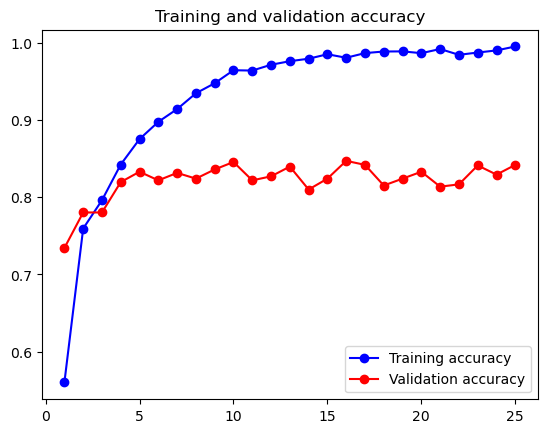

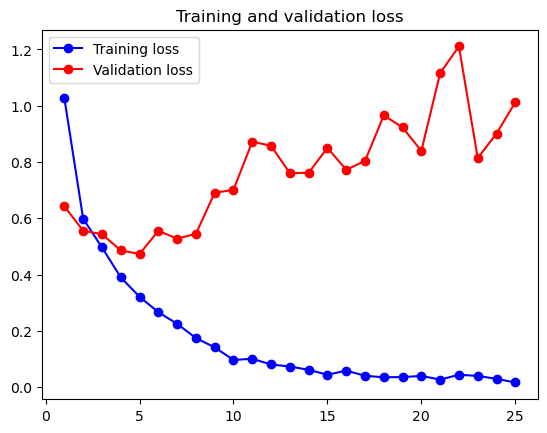

In [25]:
plot(history)

 As we can see in the plot above, there is a problem of early overfitting in the network starting in epoch 5. Thus, in the following section we will apply **regularization** to check whether it helps to increase the performance of the network.
### Test Regularization
In this section several experiments are carried out modifying the previous base architecture:
- **Batch normalization** layers can be added after the convolutional layers to make the training more stable, allowing a higher learning rate and increasing in turn the speed of the learning process. It also mitigates the drawback of random weight initialization.
- **Dropout** layers can also be used on the dense layers to eliminate the co-adaptation between them, making the network more robust to possible large individual weights of specific neurons that could dominate among the rest.
- **Data augmentation** can help to create new synthetic images increasing the number of different samples seen by the network and making the model more robust and independent of the training set.
- **Weights regularization** restricts the values of the weights to small numbers making their distribution more regular. We will test the two ways of doing this, the **L1** regularization and the **L2** regularization. 

In the following cells we will test several possible combinations of these four elements.

In [11]:
def create_scratch_model(use_batch_normalization=False, use_dropout=False, data_augmentation=None, regularizer=None):
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    # (Adjustable) Data augmentation
    if data_augmentation is not None:
        x = data_augmentation(inputs)

    # Feature extraction block
    # Convolution layer
    input_filters = 64
    if regularizer is not None:
        x = layers.Conv2D(input_filters, (3, 3), kernel_regularizer=regularizer, activation="relu")(inputs)
    else:
        x = layers.Conv2D(input_filters, (3, 3), activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # More convolution layers
    for i in range(3):  # adding variation of layers.
        if regularizer is not None:
            x = layers.Conv2D(input_filters*(2**i),  # increase depth by power of 2 for each conv layer
                              (3, 3), kernel_regularizer=regularizer, activation="relu")(x)
        else:
            x = layers.Conv2D(input_filters*(2**i),  # increase depth by power of 2 for each conv layer
                              (3, 3), activation="relu")(x)
        # (Adjustable) Batch normalization layer
        if use_batch_normalization:
            x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten layer
    x = layers.Flatten()(x)

    ##################################################
    # Classification block
    # Fully connected layers
    for i in range(3):
        if regularizer is not None:
            x = layers.Dense(128, kernel_regularizer=regularizer, activation="relu")(x)
        else:
            x = layers.Dense(128, activation="relu")(x)

        # (Adjustable) Dropout layer
        if use_dropout:
            x = layers.Dropout(rate=0.5)(x)
    
    # Output layer
    outputs = layers.Dense(5, activation="softmax")(x)

    # Prepare model
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy",keras.metrics.F1Score(),keras.metrics.Precision(),keras.metrics.Recall()]
    )

    model.summary()

    return model

In [12]:
def train_model(model, train_dataset, val_dataset, epochs=20, lr=0.001, optimizer=keras.optimizers.Adam, checkpoint=None, lr_scheduler=None, early_stop=None):

  model.compile(optimizer=optimizer(learning_rate=lr),
    loss="categorical_crossentropy",
    metrics=["accuracy",keras.metrics.F1Score(),keras.metrics.Precision(),keras.metrics.Recall()]
  )

  callbacks = []
  if checkpoint is not None:
    callbacks.append(checkpoint)
  if lr_scheduler is not None:
    callbacks.append(lr_scheduler)
  if early_stop is not None:
    callbacks.append(early_stop)

  history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks)
  return history

def execute_pipeline(train_dataset, val_dataset, hyperparameters):

  # Set the seed to ensure reproducibility
  keras.utils.set_random_seed(RANDOM_SEED)

  model = create_scratch_model(use_batch_normalization=hyperparameters["bn"], use_dropout=hyperparameters["dropout"], data_augmentation=hyperparameters["augmentation"], regularizer=hyperparameters["regularizer"])
  history = train_model(model, train_dataset, val_dataset, hyperparameters["epochs"],
                        hyperparameters["lr"], hyperparameters["optimizer"],
                        hyperparameters["checkpoint"], hyperparameters["lr_scheduler"], hyperparameters["early_stop"])
  plot(history)

  return model, history

### Hyperparameters example

In [10]:
# Example of hyperparameters
hyperparameters = {
    "epochs": 50,  # maximum number of epochs to train the network
    "lr": 0.001,  # initial learning rate of the optimizer
    "optimizer": optimizers.Adam,

    "bn": True,  # if True, perform batch normalization after the convolutional layers
    "dropout": False,  # if True, perform dropout
    
    # Set the following hyperparameters to None if you do not want to use them
    "regularizer":keras.regularizers.l2(0.001),
    "augmentation": keras.Sequential(
      [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
      ], name="augmentation"),
    "lr_scheduler": keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr if epoch < 20 else lr * tf.math.exp(-0.1)),
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + 'checkpoint_name_{epoch}.keras', 'val_loss', save_best_only=True)
}

### Experiments
First we will test every regularization technique individually to see how it affects to the resulting training plot.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856 

2024-03-02 17:28:54.572752: I external/local_xla/xla/service/service.cc:168] XLA service 0x55e57d97a1a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-02 17:28:54.572817: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-03-02 17:28:54.605399: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709396934.878862    3321 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


379/379 [==============================] - 33s 66ms/step - loss: 1.0156 - accuracy: 0.5700 - f1_score: 0.5714 - precision_1: 0.7555 - recall_1: 0.3995 - val_loss: 0.6200 - val_accuracy: 0.7491 - val_f1_score: 0.7467 - val_precision_1: 0.7929 - val_recall_1: 0.6793
Epoch 2/25
379/379 [==============================] - 20s 53ms/step - loss: 0.5670 - accuracy: 0.7729 - f1_score: 0.7721 - precision_1: 0.8205 - recall_1: 0.7153 - val_loss: 0.5270 - val_accuracy: 0.7832 - val_f1_score: 0.7857 - val_precision_1: 0.8273 - val_recall_1: 0.7327
Epoch 3/25
379/379 [==============================] - 20s 52ms/step - loss: 0.4529 - accuracy: 0.8194 - f1_score: 0.8193 - precision_1: 0.8595 - recall_1: 0.7775 - val_loss: 0.4634 - val_accuracy: 0.8151 - val_f1_score: 0.8151 - val_precision_1: 0.8498 - val_recall_1: 0.7773
Epoch 4/25
379/379 [==============================] - 21s 53ms/step - loss: 0.3718 - accuracy: 0.8549 - f1_score: 0.8549 - precision_1: 0.8836 - recall_1: 0.8259 - val_loss: 0.4626 - 

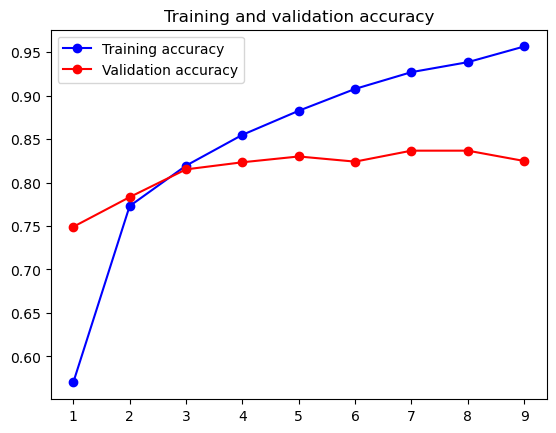

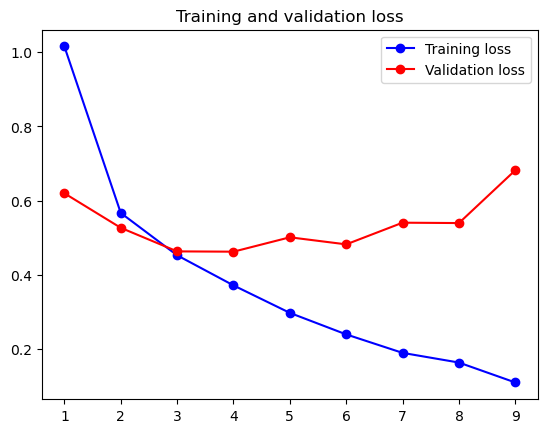

In [13]:
# Baseline model
checkpoint_filename = "/cnn_baseline_lr0.001.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "bn": False,
    "dropout": False,
    "regularizer": None,
    "augmentation": None,
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_34 (Conv2D)          (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 89, 89, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 87, 87, 64)        36928     
                                                                 
 batch_normalization_3 (Bat  (None, 87, 87, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 43, 43, 64)        0   

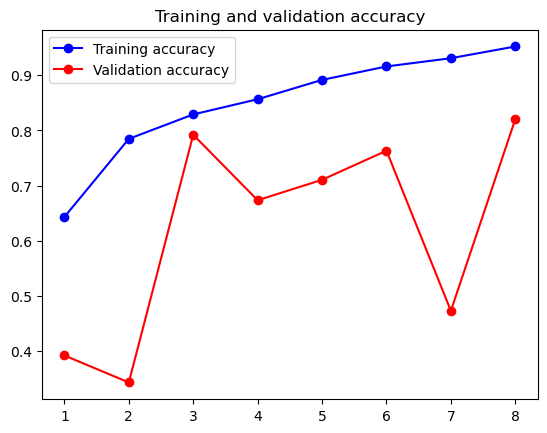

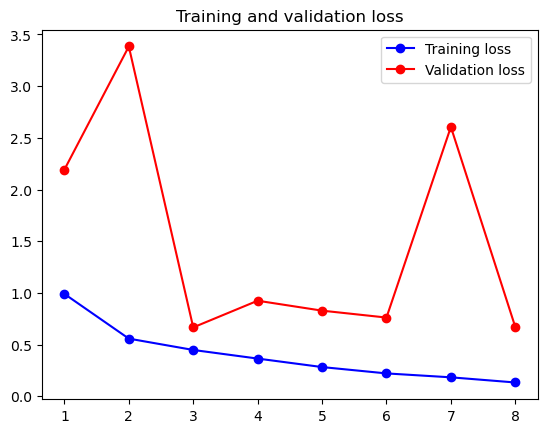

In [21]:
# Batch normalization model
checkpoint_filename = "/cnn_reg_lr0.001_bn.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "bn": True,
    "dropout": False,
    "regularizer": None,
    "augmentation": None,
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 89, 89, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 41, 41, 128)       7385

 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 5)                 645       
                                                                 
Total params: 3095749 (11.81 MB)
Trainable params: 3095749 (11.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/25
379/379 [================

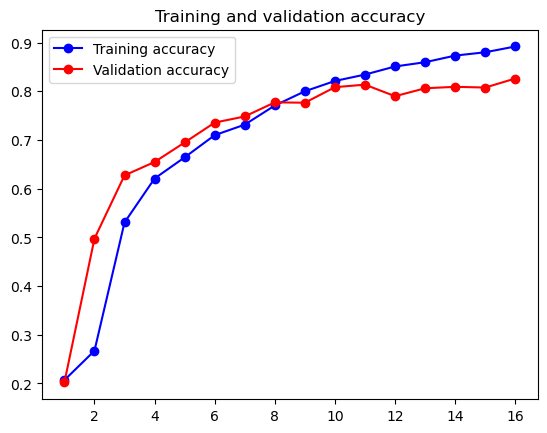

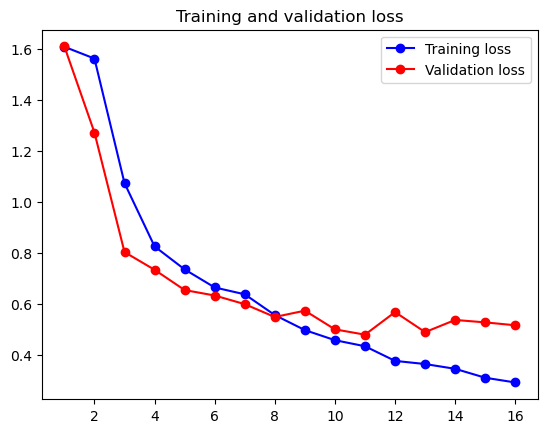

In [14]:
# Dropout model
checkpoint_filename = "/cnn_reg_lr0.001_dropout.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "bn": False,
    "dropout": True,
    "regularizer": None,
    "augmentation": None,
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_42 (Conv2D)          (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 89, 89, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 87, 87, 64)        36928     
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 41, 41, 128)       738

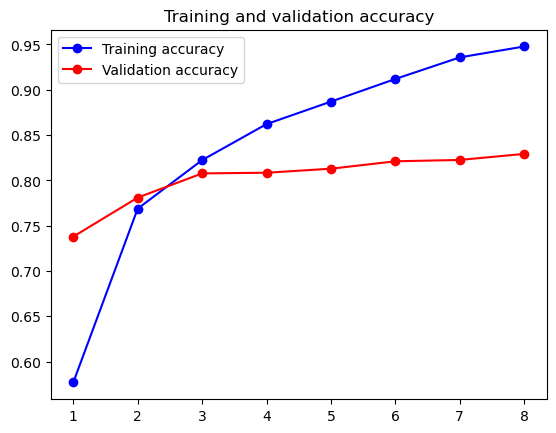

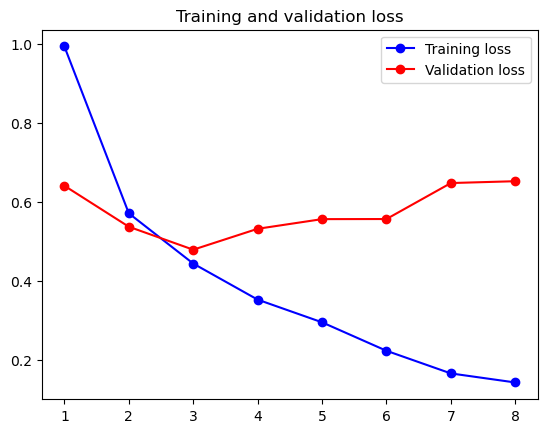

In [23]:
# Data augmentation model
checkpoint_filename = "/cnn_reg_lr0.001_da.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "bn": False,
    "dropout": False,
    "regularizer": None,
    "augmentation": keras.Sequential(
      [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
      ], name="augmentation"),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_46 (Conv2D)          (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 89, 89, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 87, 87, 64)        36928     
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 41, 41, 128)       738

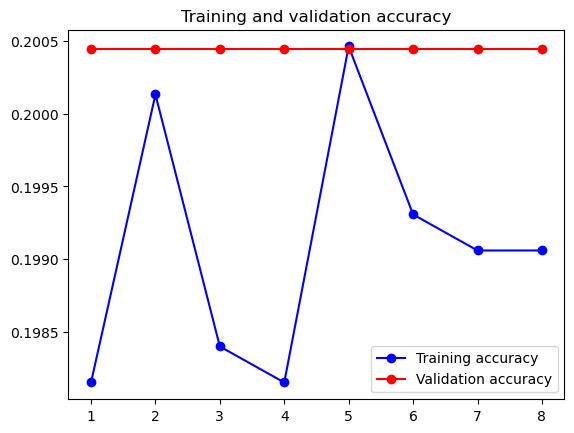

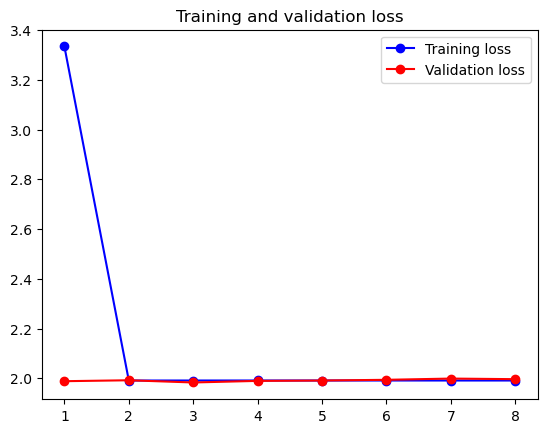

In [24]:
# L1 model
checkpoint_filename = "/cnn_reg_lr0.001_l1.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "bn": False,
    "dropout": False,
    "regularizer": keras.regularizers.l1(0.001),
    "augmentation": None,
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_22 (Conv2D)          (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 89, 89, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 87, 87, 64)        36928     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 41, 41, 128)       7385

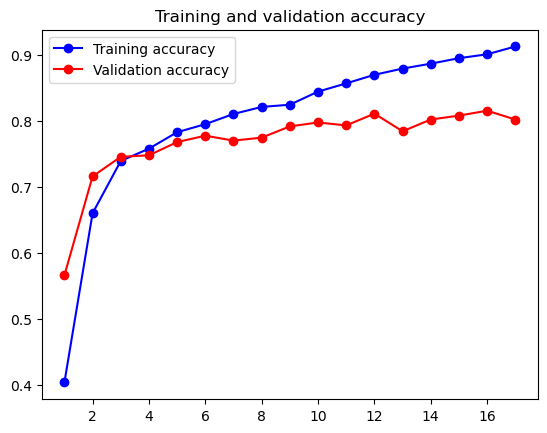

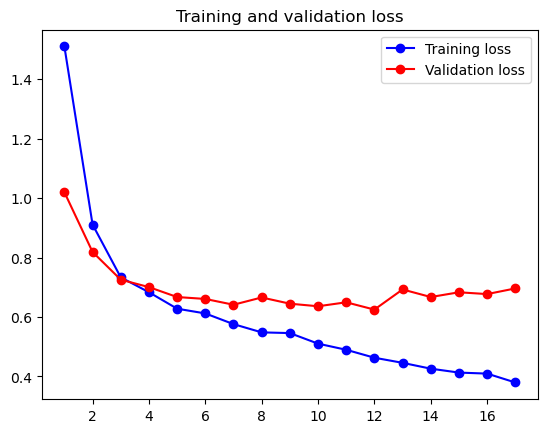

In [16]:
# L2 model
checkpoint_filename = "/cnn_reg_lr0.001_l2.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "bn": False,
    "dropout": False,
    "regularizer": keras.regularizers.l2(0.001),
    "augmentation": None,
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_26 (Conv2D)          (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 89, 89, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 87, 87, 64)        36928     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 41, 41, 128)       7385

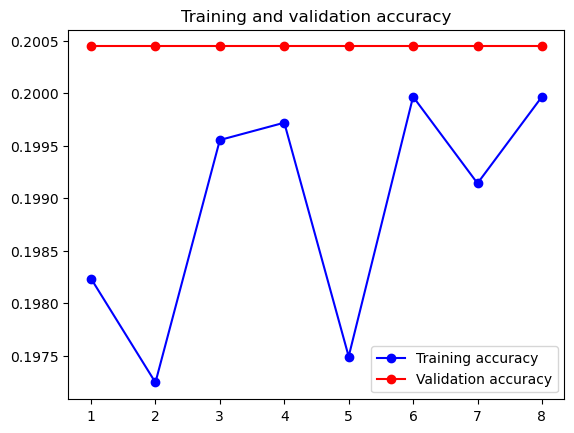

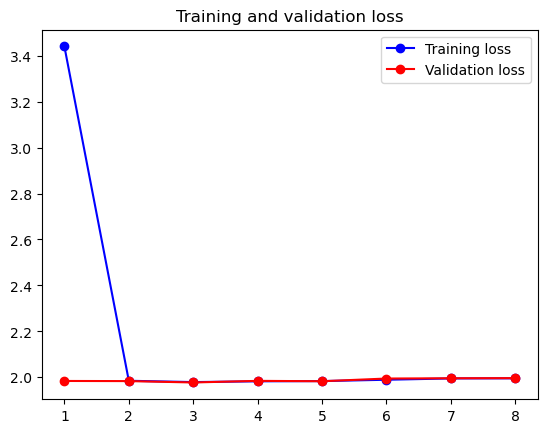

In [17]:
# L1_L2 model
checkpoint_filename = "/cnn_reg_lr0.001_l1_l2.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "bn": False,
    "dropout": False,
    "regularizer": keras.regularizers.l1_l2(l1=0.001, l2=0.001),
    "augmentation": None,
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_50 (Conv2D)          (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 89, 89, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 87, 87, 64)        36928     
                                                                 
 max_pooling2d_50 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_52 (Conv2D)          (None, 41, 41, 128)       738

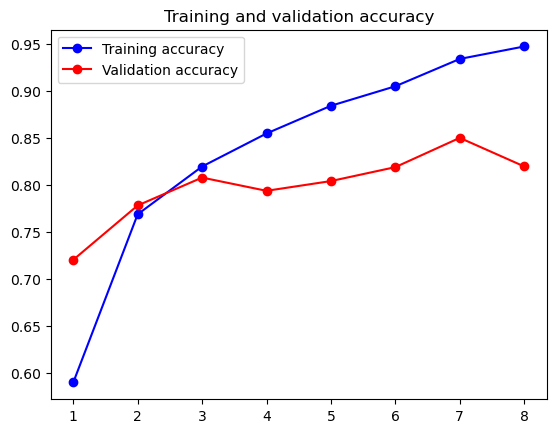

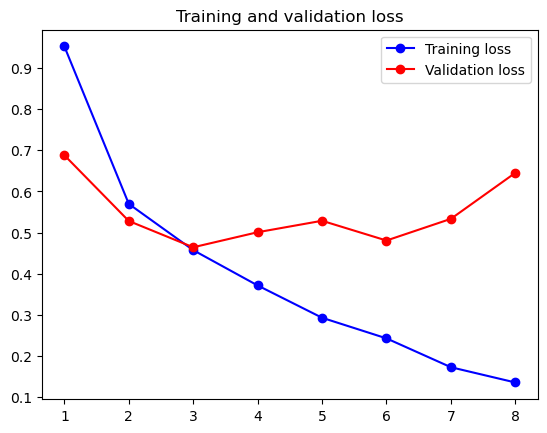

In [25]:
# Learning rate scheduler model
checkpoint_filename = "/cnn_reg_lr0.001_lrScheduler.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "bn": False,
    "dropout": False,
    "regularizer": None,
    "augmentation": None,
    "lr_scheduler": keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr if epoch < 20 else lr * tf.math.exp(-0.1)),
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

First of all, we have tried using batch normalization layers after the convolutional layers to make the training faster and more stable. However, it did not seem to reduce overfitting and even affected the loss curve making the training much more inestable. On the other hand, using dropout and data normalization seemed to affect positively to training, specially the former one which achieved to delay the overfitting emergence to the epoch 7 and obtaining a validation accuracy of ~0.82, slighly lower than the baseline model.

Regarding weight regularization, L1 regularization makes the model completely unable to learn the patterns from the dataset, returning a validacion_accuracy of 0.2 (random classification since there are 5 classes). L1 regularization is generally considered to generate models that are simple and interpretable but not capable of learning complex patterns, which highlights the necesity of learning complex patterns in our dataset. The same occurs when combined with L2.

However, applying L2 regularization we achieve to stabilize the training delaying the overfitting emergence until epoch 12 and obtaining a validation accuracy of 0.8159.

Let's try now combining some of the techniques which seemed to deal with the overfitting problem. First, we will combine Dropout with Data augmentation and see what happens.

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 89, 89, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 87, 87, 64)        36928     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 41, 41, 128)       7385

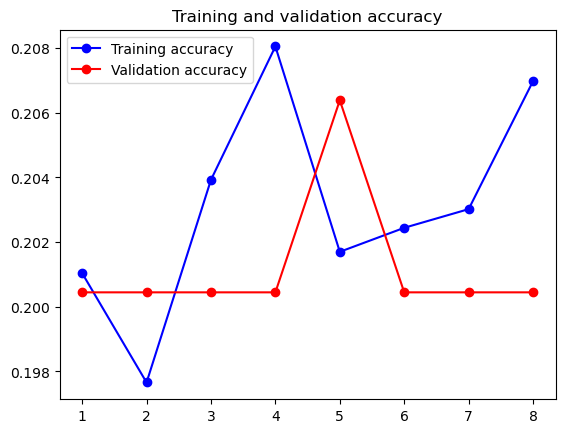

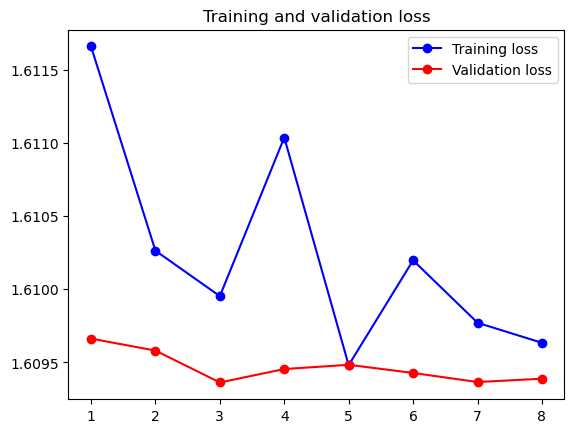

In [15]:
# Dropout augmented model
checkpoint_filename = "/cnn_reg_lr0.001_dropout_aug.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "bn": False,
    "dropout": True,
    "regularizer": None,
    "augmentation": keras.Sequential(
      [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
      ], name="augmentation"),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

As we can see in the plot above, the model updates the weights too drastically causing a inestability in the training. This situation seems to be caused by a too high learning rate. Below we will test what happens if we vary this parameter.

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 89, 89, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 87, 87, 64)        36928     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 41, 41, 128)       7385

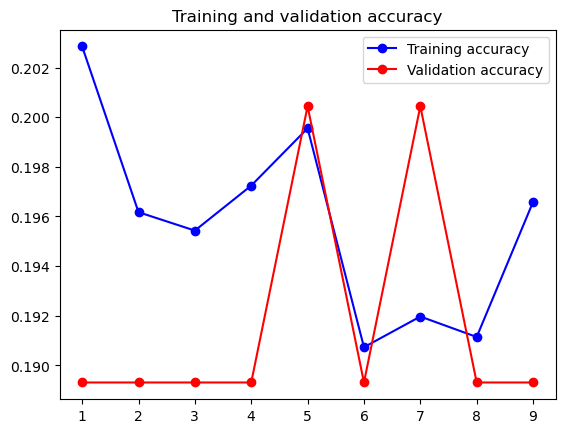

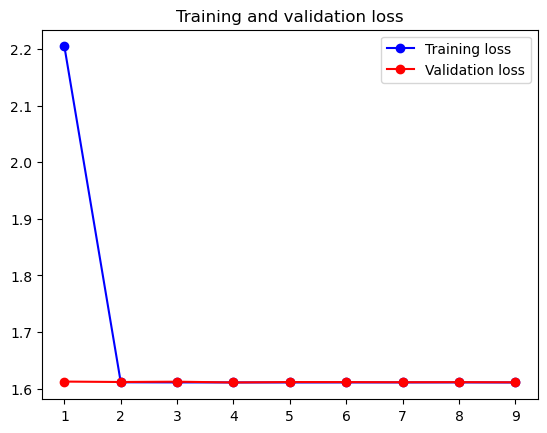

In [16]:
# Dropout augmented model, with higher learning rate
checkpoint_filename = "/cnn_reg_lr0.01_dropout_aug.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.01,
    "optimizer": optimizers.Adam,

    "bn": False,
    "dropout": True,
    "regularizer": None,
    "augmentation": keras.Sequential(
      [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
      ], name="augmentation"),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_24 (Conv2D)          (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 89, 89, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 87, 87, 64)        36928     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 41, 41, 128)       7385

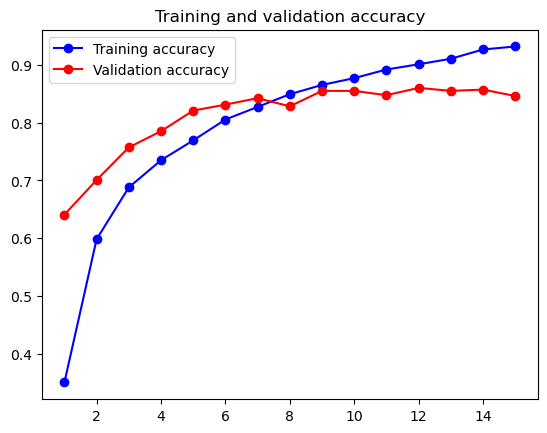

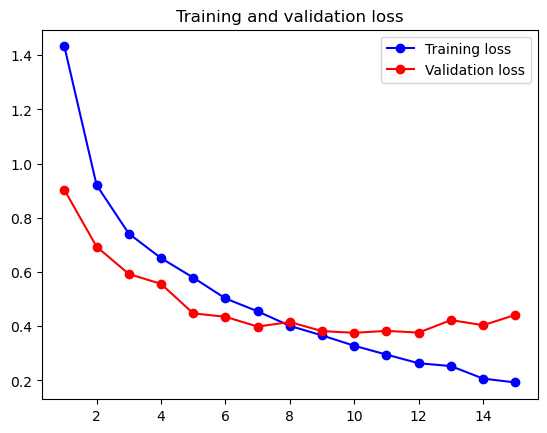

In [17]:
# Dropout augmented model, with lower learning rate
checkpoint_filename = "/cnn_reg_lr0.0005_dropout_aug.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.0005,
    "optimizer": optimizers.Adam,

    "bn": False,
    "dropout": True,
    "regularizer": None,
    "augmentation": keras.Sequential(
      [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
      ], name="augmentation"),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

As we expected, the learning rate was too high. Reducing it to 0.0005 allowed to stabilize the training and obtain a ~0.86 validation accuracy avoiding early overfitting problems as well. Having as a goal to reach the 90% in validation accuracy, we decided to repeat the previous process adding a learning rate scheduler to progressively reduce the learning rate value (**Learning rate decay**) and then test adding L2 regularization which provided good results in the previous experiments. 

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 87, 87, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 41, 41, 128)       7385

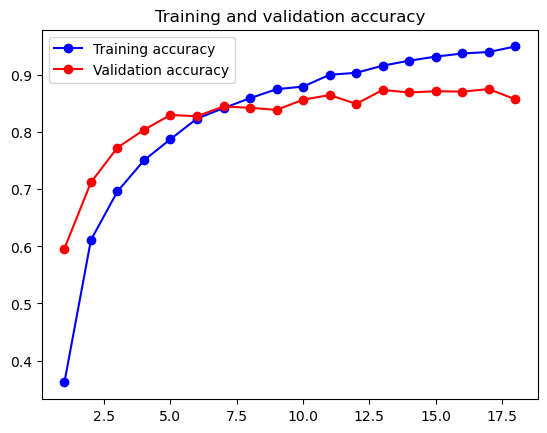

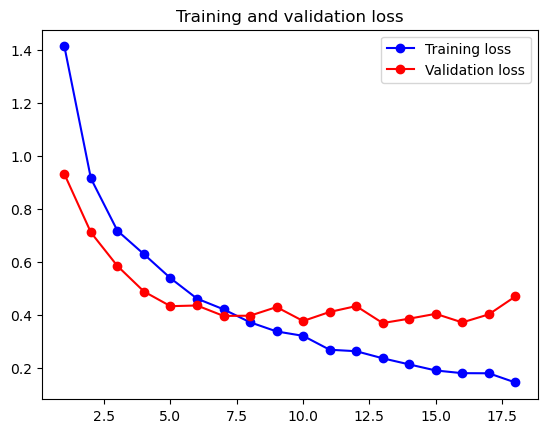

In [9]:
# Dropout augmented model with learning rate scheduler
checkpoint_filename = "/cnn_reg_lr0.0005_dropout_aug_lrScheduler.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.0005,
    "optimizer": optimizers.Adam,

    "bn": False,
    "dropout": True,
    "regularizer": None,
    "augmentation": keras.Sequential(
      [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
      ], name="augmentation"),
    "lr_scheduler": keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr if epoch < 20 else lr * tf.math.exp(-0.1)),
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 89, 89, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 41, 41, 128)       7385

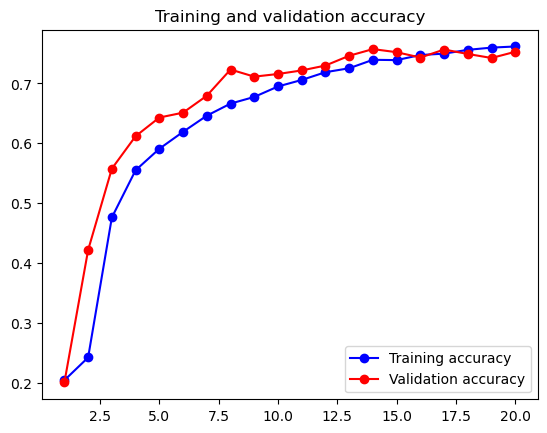

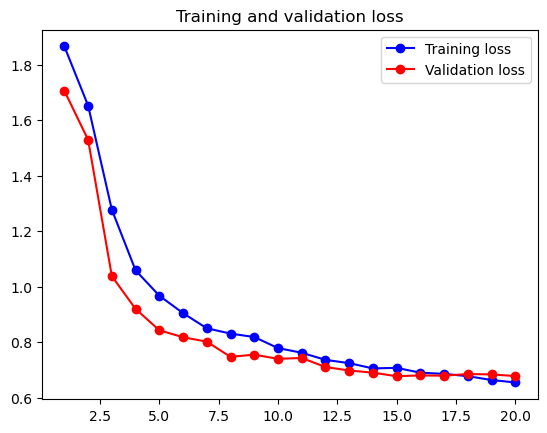

In [10]:
# Dropout augmented model with l2 and learning rate scheduler
checkpoint_filename = "/cnn_reg_lr0.0005_dropout_aug_l2_lrScheduler.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.0005,
    "optimizer": optimizers.Adam,

    "bn": False,
    "dropout": True,
    "regularizer": keras.regularizers.l2(0.001),
    "augmentation": keras.Sequential(
      [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
      ], name="augmentation"),
    "lr_scheduler": keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr if epoch < 20 else lr * tf.math.exp(-0.1)),
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

The combination of dropout with data augmentation and learning rate scheduler provides the **best results** with a validation accuracy around 0.88. However adding L2 regularization, though it did not affect to the training stability, reduced considerably the classification performance.

### ARCHITECTURE 2

We will test another hand-crafted architecture arbitrarily defined just with experimental purposes:
- **Depth of the first convolutional layer** (input_units): 32
- **Kernel size of the convolutional layers** (kernel_size): 3
- **Blocks of convolution and max-pooling** (n_layers): 2
- **Number of convolutional layers followed by a max-pooling layer** (n_conv): 2
- **Number of dense layers in the classification block** (n_connections): 1
- **Number of units in a dense layer** (n_nodes): 512

Same as in the previous experiment we will perform a full training without `EarlyStopping` to more clearly see the effects of possible overfitting and whether our model needs regularization. Then we will modify the network with different regularization techniques trying to maximize its performance and reduce the overfitting problem.

In [4]:
def create_scratch_model_2(use_batch_normalization=False, use_dropout=False, data_augmentation=None, regularizer=None):
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    # (Adjustable) Data augmentation
    if data_augmentation is not None:
        x = data_augmentation(inputs)

    # Feature extraction block
    # Convolution layer
    input_filters = 32
    if regularizer is not None:
        x = layers.Conv2D(input_filters, (3, 3), kernel_regularizer=regularizer, activation="relu")(inputs)
        x = layers.Conv2D(input_filters, (3, 3), kernel_regularizer=regularizer, activation="relu")(x)
    else:
        x = layers.Conv2D(input_filters, (3, 3), activation="relu")(inputs)
        x = layers.Conv2D(input_filters, (3, 3), activation="relu")(x)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # More convolution layers
    for i in range(2):  # adding variation of layers.
        for j in range(3): # number of convolutions before a pooling
            if regularizer is not None:
                x = layers.Conv2D(input_filters*(2**i),  # increase depth by power of 2 for each conv layer
                                (3, 3), kernel_regularizer=regularizer, activation="relu")(x)
            else:
                x = layers.Conv2D(input_filters*(2**i),  # increase depth by power of 2 for each conv layer
                                (3, 3), activation="relu")(x)
                
        # (Adjustable) Batch normalization layer
        if use_batch_normalization:
            x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten layer
    x = layers.Flatten()(x)

    ##################################################
    # Classification block
    # Fully connected layers
    if regularizer is not None:
        x = layers.Dense(512, kernel_regularizer=regularizer, activation="relu")(x)
    else:
        x = layers.Dense(512, activation="relu")(x)
    
    # (Adjustable) Dropout layer
    if use_dropout:
        x = layers.Dropout(rate=0.5)(x)

    # Output layer
    outputs = layers.Dense(5, activation="softmax")(x)

    # Prepare model
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy",keras.metrics.F1Score(),keras.metrics.Precision(),keras.metrics.Recall()]
    )

    model.summary()

    return model

In [5]:
def train_model(model, train_dataset, val_dataset, epochs=20, lr=0.001, optimizer=keras.optimizers.Adam, checkpoint=None, lr_scheduler=None, early_stop=None):

  model.compile(optimizer=optimizer(learning_rate=lr),
    loss="categorical_crossentropy",
    metrics=["accuracy",keras.metrics.F1Score(),keras.metrics.Precision(),keras.metrics.Recall()]
  )

  callbacks = []
  if checkpoint is not None:
    callbacks.append(checkpoint)
  if lr_scheduler is not None:
    callbacks.append(lr_scheduler)
  if early_stop is not None:
    callbacks.append(early_stop)

  history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks)
  return history

def execute_pipeline(train_dataset, val_dataset, hyperparameters):

  # Set the seed to ensure reproducibility
  keras.utils.set_random_seed(RANDOM_SEED)

  model = create_scratch_model_2(use_batch_normalization=hyperparameters["bn"], use_dropout=hyperparameters["dropout"], data_augmentation=hyperparameters["augmentation"], regularizer=hyperparameters["regularizer"])
  history = train_model(model, train_dataset, val_dataset, hyperparameters["epochs"],
                        hyperparameters["lr"], hyperparameters["optimizer"],
                        hyperparameters["checkpoint"], hyperparameters["lr_scheduler"], hyperparameters["early_stop"])
  plot(history)

  return model, history

### Experiments
First we will test every regularization technique individually to see how it affects to the resulting training plot.

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_205 (Conv2D)         (None, 178, 178, 32)      896       
                                                                 
 conv2d_206 (Conv2D)         (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_115 (MaxPool  (None, 88, 88, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_207 (Conv2D)         (None, 86, 86, 32)        9248      
                                                                 
 conv2d_208 (Conv2D)         (None, 84, 84, 32)        9248      
                                                          

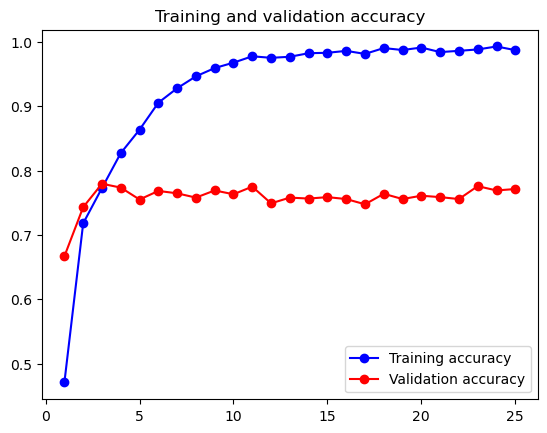

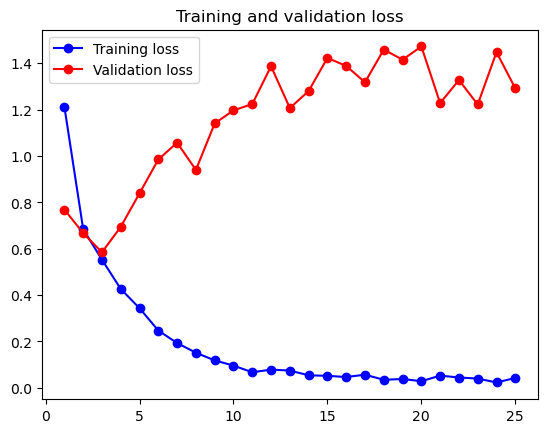

In [50]:
# Baseline model
checkpoint_filename = "/cnn2_lr0.001.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "bn": False,
    "dropout": True,
    "regularizer": None,
    "augmentation": None,
    "lr_scheduler": None,
    "early_stop": None,
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

Same as in the previous approximation there is a problem of early overfitting in the network starting in epoch 3, even earlier. Thus, in the following subsection we will apply **regularization** to check whether it helps to increase the performance of the network.
### Test Regularization
In this section several experiments are carried out modifying the previous base architecture:
- **Batch normalization** layers can be added after the convolutional layers to make the training more stable, allowing a higher learning rate and increasing in turn the speed of the learning process. It also mitigates the drawback of random weight initialization.
- **Dropout** layers can also be used on the dense layers to eliminate the co-adaptation between them, making the network more robust to possible large individual weights of specific neurons that could dominate among the rest.
- **Data augmentation** can help to create new synthetic images increasing the number of different samples seen by the network and making the model more robust and independent of the training set.
- **Weights regularization** restricts the values of the weights to small numbers making their distribution more regular. We will test the two ways of doing this, the **L1** regularization and the **L2** regularization. 

In the following cells we will test several possible combinations of these four elements.

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_213 (Conv2D)         (None, 178, 178, 32)      896       
                                                                 
 conv2d_214 (Conv2D)         (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_118 (MaxPool  (None, 88, 88, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_215 (Conv2D)         (None, 86, 86, 32)        9248      
                                                                 
 conv2d_216 (Conv2D)         (None, 84, 84, 32)        9248      
                                                          

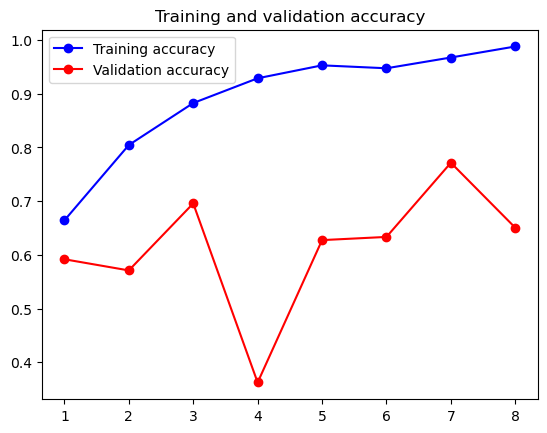

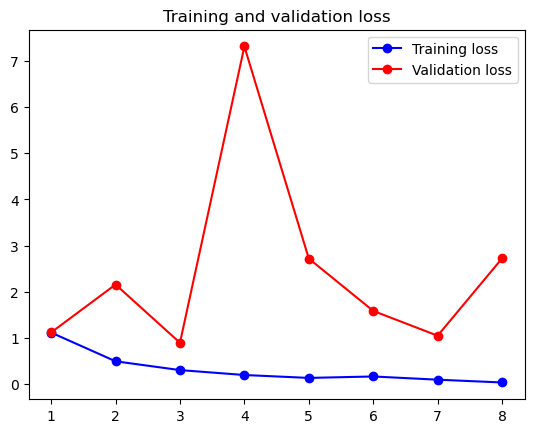

In [51]:
# Batch normalization model
checkpoint_filename = "/cnn2_reg_lr0.001_bn.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "bn": True,
    "dropout": False,
    "regularizer": None,
    "augmentation": None,
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_221 (Conv2D)         (None, 178, 178, 32)      896       
                                                                 
 conv2d_222 (Conv2D)         (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_121 (MaxPool  (None, 88, 88, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_223 (Conv2D)         (None, 86, 86, 32)        9248      
                                                                 
 conv2d_224 (Conv2D)         (None, 84, 84, 32)        9248      
                                                          

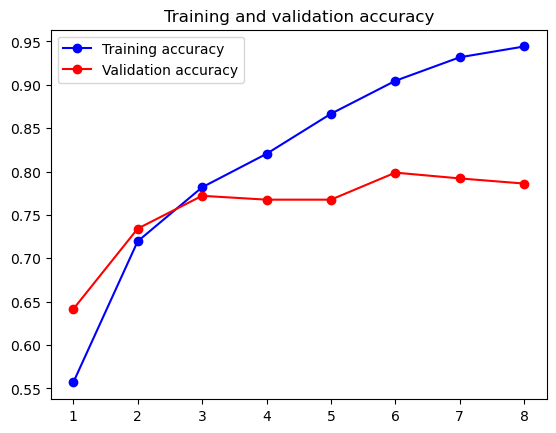

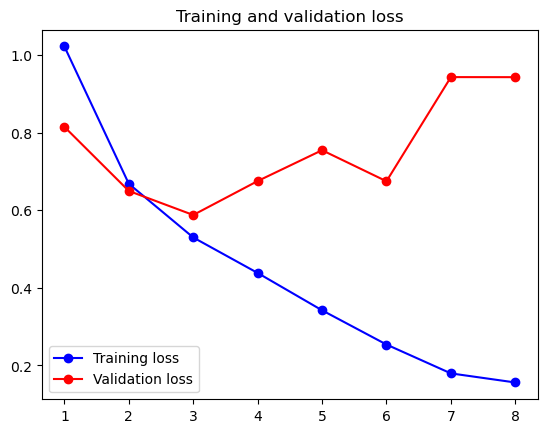

In [52]:
# Dropout model
checkpoint_filename = "/cnn2_reg_lr0.001_dropout.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "bn": False,
    "dropout": True,
    "regularizer": None,
    "augmentation": None,
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_229 (Conv2D)         (None, 178, 178, 32)      896       
                                                                 
 conv2d_230 (Conv2D)         (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_124 (MaxPool  (None, 88, 88, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_231 (Conv2D)         (None, 86, 86, 32)        9248      
                                                                 
 conv2d_232 (Conv2D)         (None, 84, 84, 32)        9248      
                                                          

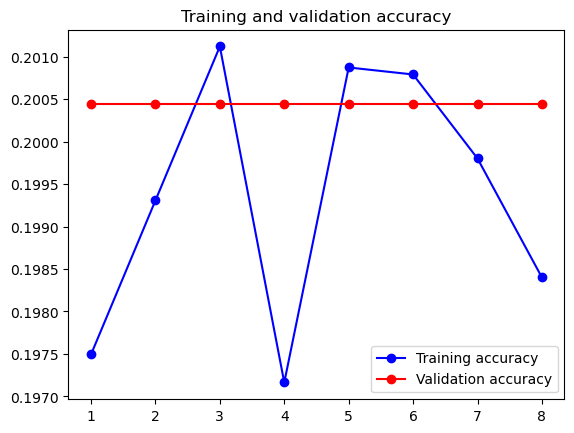

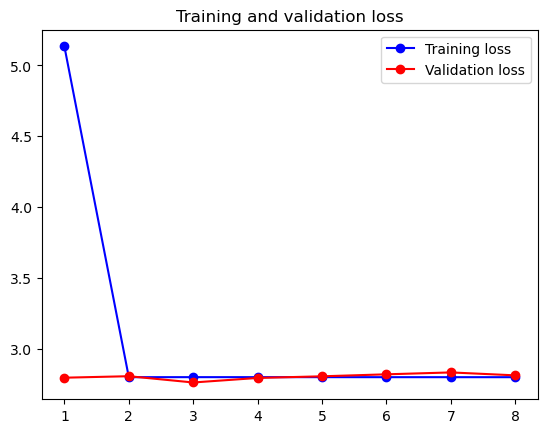

In [53]:
# L1 model
checkpoint_filename = "/cnn2_reg_lr0.001_l1.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "bn": False,
    "dropout": False,
    "regularizer": keras.regularizers.l1(0.001),
    "augmentation": None,
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_237 (Conv2D)         (None, 178, 178, 32)      896       
                                                                 
 conv2d_238 (Conv2D)         (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_127 (MaxPool  (None, 88, 88, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_239 (Conv2D)         (None, 86, 86, 32)        9248      
                                                                 
 conv2d_240 (Conv2D)         (None, 84, 84, 32)        9248      
                                                          

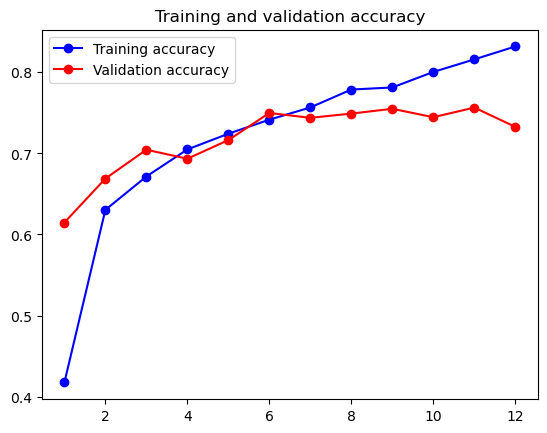

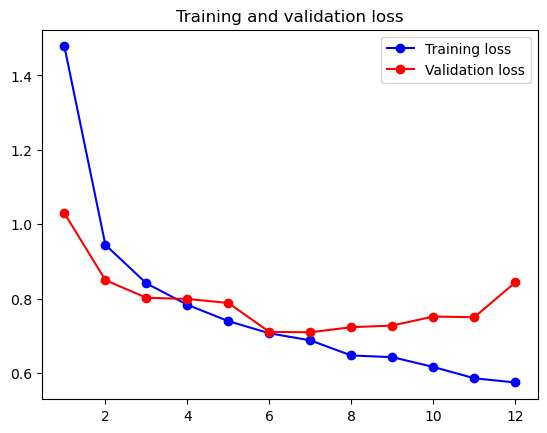

In [54]:
# L2 model
checkpoint_filename = "/cnn2_reg_lr0.001_l2.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "bn": False,
    "dropout": False,
    "regularizer": keras.regularizers.l2(0.001),
    "augmentation": None,
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_245 (Conv2D)         (None, 178, 178, 32)      896       
                                                                 
 conv2d_246 (Conv2D)         (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_130 (MaxPool  (None, 88, 88, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_247 (Conv2D)         (None, 86, 86, 32)        9248      
                                                                 
 conv2d_248 (Conv2D)         (None, 84, 84, 32)        9248      
                                                          

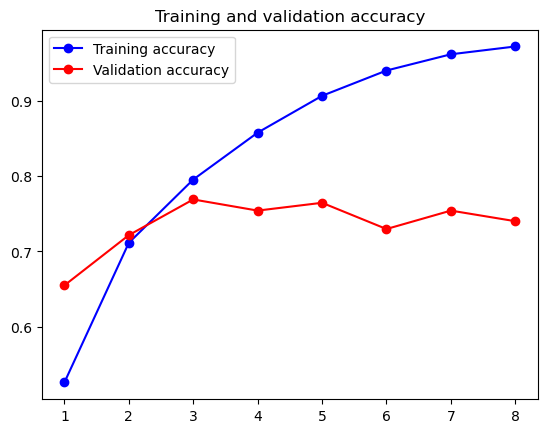

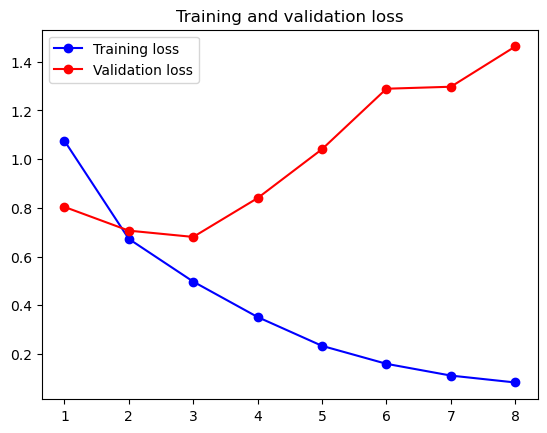

In [55]:
# Data augmentation model
checkpoint_filename = "/cnn2_reg_lr0.001_da.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "bn": False,
    "regularizer": None,
    "dropout": False,
    "augmentation": keras.Sequential(
      [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
      ], name="augmentation"),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 84, 84, 32)        9248      
                                                             

2024-02-24 20:19:18.465209: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-24 20:19:21.879486: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f78500393e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-24 20:19:21.879523: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-02-24 20:19:21.891985: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708802361.998434    2629 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


379/379 [==============================] - 61s 118ms/step - loss: 1.7337 - accuracy: 0.2015 - f1_score: 0.1617 - precision_1: 0.3226 - recall_1: 8.2461e-04 - val_loss: 1.6411 - val_accuracy: 0.2004 - val_f1_score: 0.0668 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/25
379/379 [==============================] - 34s 89ms/step - loss: 1.6296 - accuracy: 0.1963 - f1_score: 0.1317 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.6212 - val_accuracy: 0.2004 - val_f1_score: 0.0668 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/25
379/379 [==============================] - 34s 88ms/step - loss: 1.6175 - accuracy: 0.1969 - f1_score: 0.1253 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.6143 - val_accuracy: 0.2004 - val_f1_score: 0.0668 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/25
379/379 [==============================] - 32s 82ms/step - loss: 1.6128 - accuracy: 0.1977 - f1_score: 0.1158 - precision_1: 0.

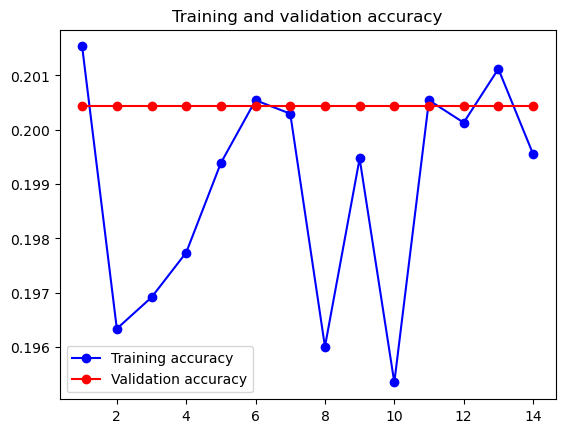

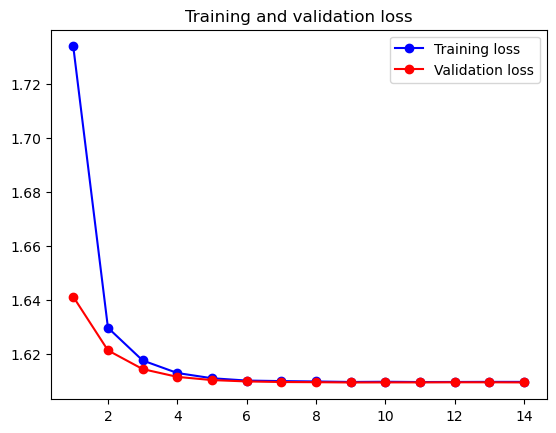

In [7]:
# Dropout augmented L2 model
checkpoint_filename = "/cnn2_reg_lr0.001_dropout_aug.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "bn": False,
    "regularizer": keras.regularizers.l2(0.001),
    "dropout": True,
    "augmentation": keras.Sequential(
      [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
      ], name="augmentation"),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 84, 84, 32)        9248      
                                                             

2024-02-28 22:20:16.274744: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-28 22:20:18.679481: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5c501aa080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-28 22:20:18.679519: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-02-28 22:20:18.691778: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709155218.803094   47295 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


379/379 [==============================] - 37s 70ms/step - loss: 1.0341 - accuracy: 0.5702 - f1_score: 0.5721 - precision_1: 0.7375 - recall_1: 0.3952 - val_loss: 0.6600 - val_accuracy: 0.7424 - val_f1_score: 0.7446 - val_precision_1: 0.8004 - val_recall_1: 0.6607 - lr: 5.0000e-04
Epoch 2/25
379/379 [==============================] - 21s 55ms/step - loss: 0.6207 - accuracy: 0.7508 - f1_score: 0.7501 - precision_1: 0.8081 - recall_1: 0.6813 - val_loss: 0.5742 - val_accuracy: 0.7721 - val_f1_score: 0.7724 - val_precision_1: 0.8228 - val_recall_1: 0.7171 - lr: 5.0000e-04
Epoch 3/25
379/379 [==============================] - 22s 56ms/step - loss: 0.5013 - accuracy: 0.8016 - f1_score: 0.8012 - precision_1: 0.8467 - recall_1: 0.7512 - val_loss: 0.5403 - val_accuracy: 0.7854 - val_f1_score: 0.7905 - val_precision_1: 0.8258 - val_recall_1: 0.7424 - lr: 5.0000e-04
Epoch 4/25
379/379 [==============================] - 21s 55ms/step - loss: 0.4128 - accuracy: 0.8366 - f1_score: 0.8366 - precision

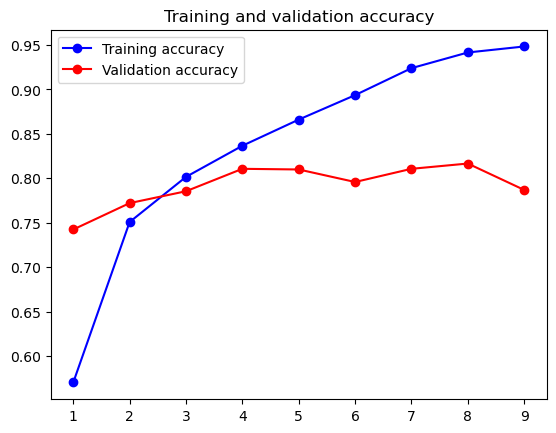

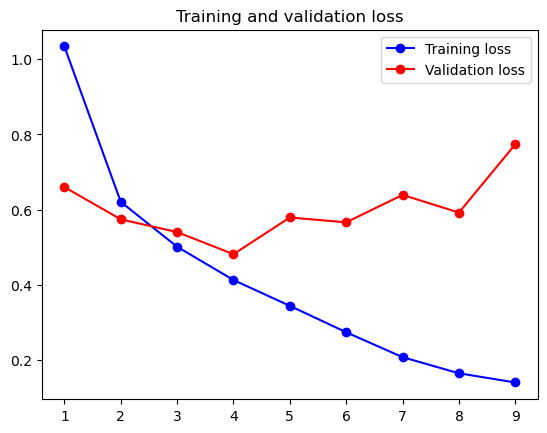

In [6]:
# Dropout augmented model with learning rate scheduler
checkpoint_filename = "/cnn2_reg_lr0.0005_dropout_aug_lrScheduler.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.0005,
    "optimizer": optimizers.Adam,

    "bn": False,
    "regularizer": None,
    "dropout": True,
    "augmentation": keras.Sequential(
      [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
      ], name="augmentation"),
    "lr_scheduler": keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr if epoch < 20 else lr * tf.math.exp(-0.1)),
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

In this approach we encountered the same problems as with the first architecture, so refer to it for further explanations and discussion. However, in general the results of the different experiments are much lower highlighting the importance of the initial hyperparameter tuning process for finding the architecture most suitable for our problem.

Again, the **model with dropout, data augmentation and the learning rate scheduler** achieved to maximize the performance of the architecture but only reaching a validation accuracy of ~0.8.

### Complex architectures
To end with this section let's test more complex architectures (without pre-training): **InceptionResNetV2, VGG16, VGG19, Inception, Xception and Residual**

In [14]:
# Functions to define architectures
def create_complex_model(architecture, dropout=False, data_augmentation=None):  
  inputs = keras.Input(shape=(180, 180, 3))

  if data_augmentation is not None:
    x = data_augmentation(inputs)
    x = architecture(include_top=False, weights=None, input_tensor=None, input_shape=(180,180,3), pooling="max")(x)
  else:
    x = architecture(include_top=False, weights=None, input_tensor=None, input_shape=(180,180,3), pooling="max")(inputs)

  x = layers.Flatten()(x)
  
  # Replace the whole classificator module since they are different problems
  x = layers.Dense(256, activation="relu")(x)
  if (dropout):
    x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(5, activation="softmax")(x)

  model = keras.Model(inputs, outputs)

  model.summary()
  
  return model

def train_model(model, train_dataset, val_dataset, epochs=20, lr=0.001, optimizer=keras.optimizers.Adam, checkpoint=None, lr_scheduler=None, early_stop=None):

  model.compile(optimizer=optimizer(learning_rate=lr),
    loss="categorical_crossentropy",
    metrics=["accuracy",keras.metrics.F1Score(),keras.metrics.Precision(),keras.metrics.Recall()]
  )

  callbacks = []
  if checkpoint is not None:
    callbacks.append(checkpoint)
  if lr_scheduler is not None:
    callbacks.append(lr_scheduler)
  if early_stop is not None:
    callbacks.append(early_stop)

  history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks)
  return history

def execute_pipeline_complex(train_dataset, val_dataset, hyperparameters):

  # Set the seed to ensure reproducibility
  keras.utils.set_random_seed(RANDOM_SEED)

  # Create and train model
  model = create_complex_model(hyperparameters["architecture"], hyperparameters["dropout"], hyperparameters["data_augmentation"])
  history = train_model(model, train_dataset, val_dataset, hyperparameters["epochs"],
                        hyperparameters["lr"], hyperparameters["optimizer"],
                        hyperparameters["checkpoint"], hyperparameters["lr_scheduler"], hyperparameters["early_stop"])
  plot(history)

  return model, history

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 inception_resnet_v2 (Funct  (None, 1536)              54336736  
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 1536)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                           

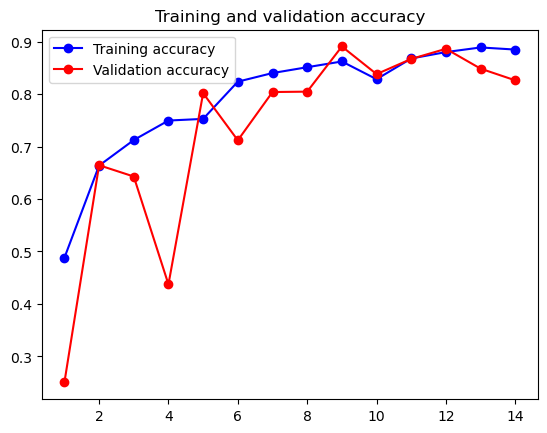

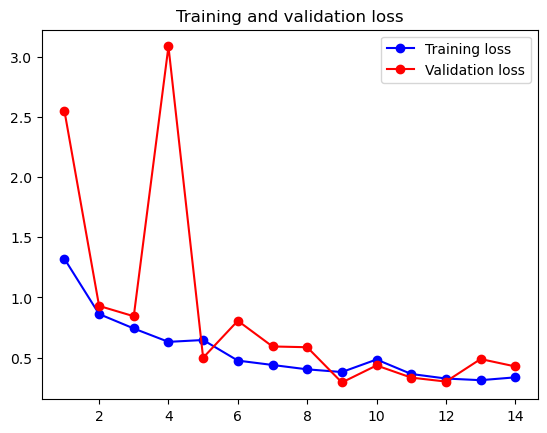

In [15]:
# InceptionResNetV2
checkpoint_filename = "/InceptionResNetV2_lr0.001.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "architecture": applications.InceptionResNetV2,

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),

    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline_complex(train_dataset, val_dataset, hyperparameters)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 5)                 1285

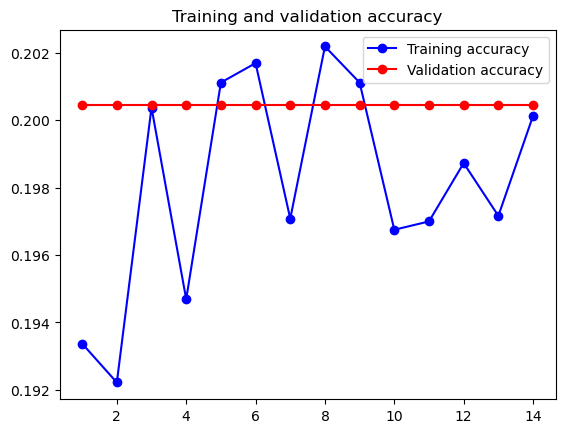

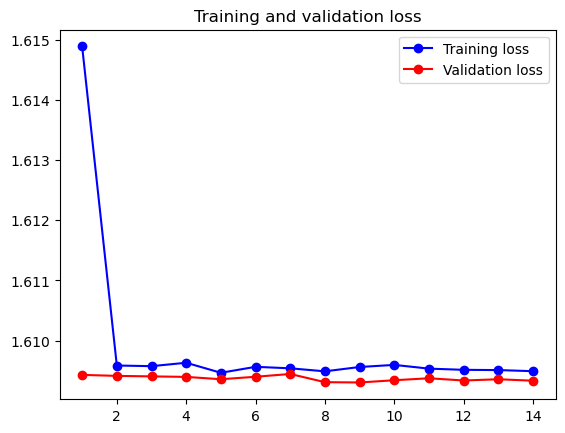

In [16]:
# VGG16
checkpoint_filename = "/vgg16_lr0.001.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "architecture": applications.vgg16.VGG16,

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),

    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None 
}

model, history = execute_pipeline_complex(train_dataset, val_dataset, hyperparameters)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_6 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_7 (Flatten)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 5)                 1285

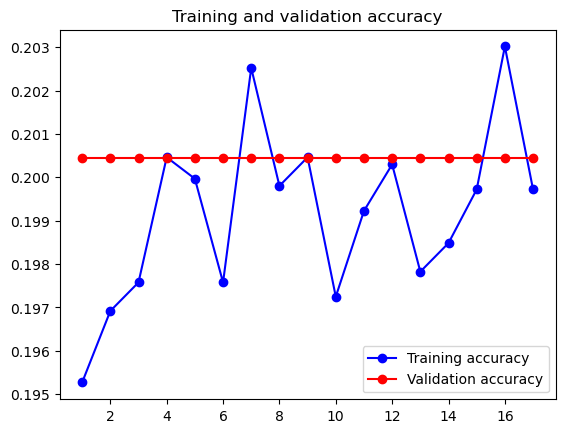

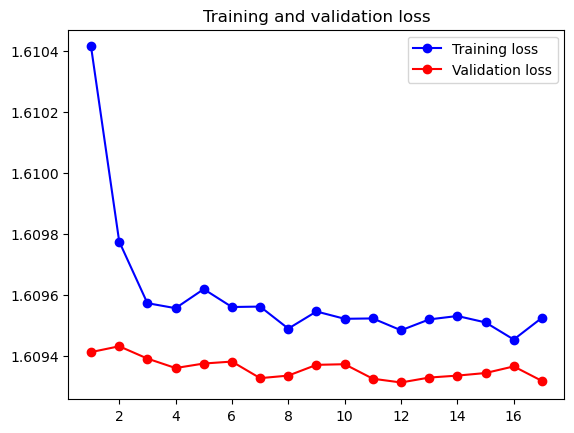

In [17]:
# VGG19
checkpoint_filename = "/vgg19_lr0.001.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "architecture": applications.vgg19.VGG19,

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),

    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline_complex(train_dataset, val_dataset, hyperparameters)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_8 (Flatten)         (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 256)               524544    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 5)                 1285

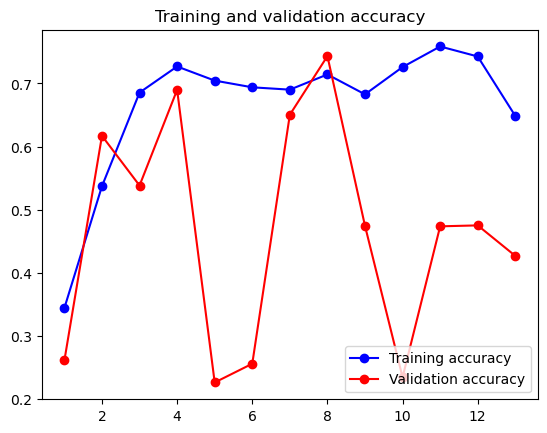

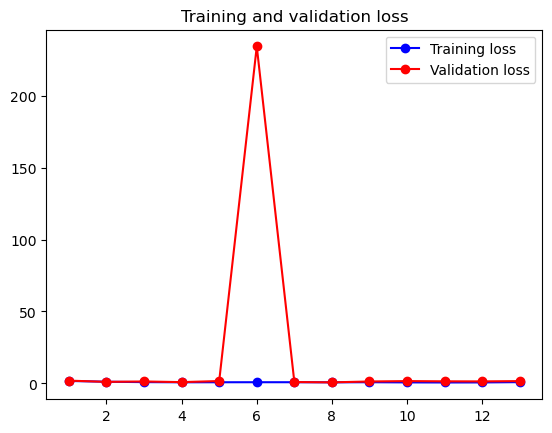

In [18]:
# Inception
checkpoint_filename = "/inception_lr0.001.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "architecture": applications.InceptionV3,

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),

    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline_complex(train_dataset, val_dataset, hyperparameters)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_11 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_12 (Flatten)        (None, 2048)              0         
                                                                 
 dense_24 (Dense)            (None, 256)               524544    
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 5)                 128

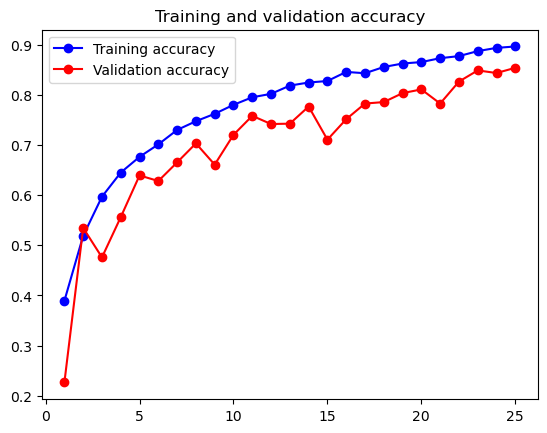

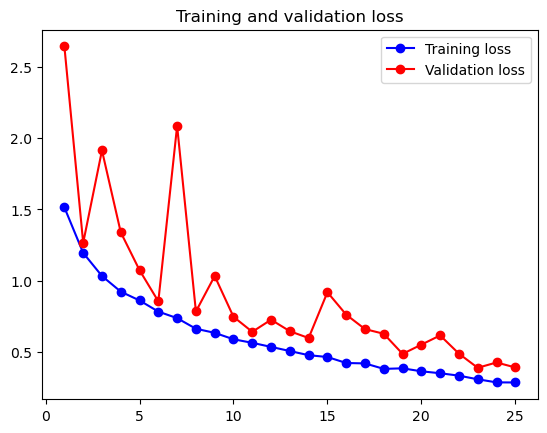

In [22]:
# Inception with lower learning rate
checkpoint_filename = "/inception_lr0.0001.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.0001,
    "optimizer": optimizers.Adam,

    "architecture": applications.InceptionV3,

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),

    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline_complex(train_dataset, val_dataset, hyperparameters)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285  

2024-02-29 20:46:01.066942: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-29 20:46:05.050554: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4c0cc72ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-29 20:46:05.050589: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-02-29 20:46:05.064587: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709235965.168577   39188 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


379/379 [==============================] - 111s 219ms/step - loss: 1.4722 - accuracy: 0.4049 - f1_score: 0.4020 - precision: 0.5197 - recall: 0.1380 - val_loss: 1.6391 - val_accuracy: 0.2027 - val_f1_score: 0.0689 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
379/379 [==============================] - 74s 192ms/step - loss: 1.0635 - accuracy: 0.5442 - f1_score: 0.5442 - precision: 0.7080 - recall: 0.3345 - val_loss: 0.9161 - val_accuracy: 0.6221 - val_f1_score: 0.6054 - val_precision: 0.7670 - val_recall: 0.4692
Epoch 3/25
379/379 [==============================] - 74s 193ms/step - loss: 0.8547 - accuracy: 0.6378 - f1_score: 0.6366 - precision: 0.7721 - recall: 0.4740 - val_loss: 0.8612 - val_accuracy: 0.6555 - val_f1_score: 0.6407 - val_precision: 0.7704 - val_recall: 0.5108
Epoch 4/25
379/379 [==============================] - 72s 189ms/step - loss: 0.7427 - accuracy: 0.6971 - f1_score: 0.6982 - precision: 0.8038 - recall: 0.5620 - val_loss: 0.8774 - val_accuracy: 0

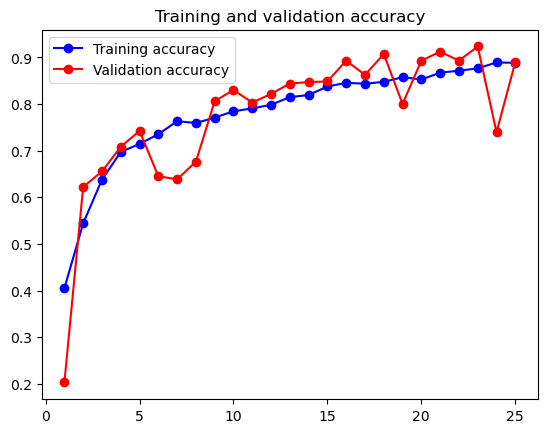

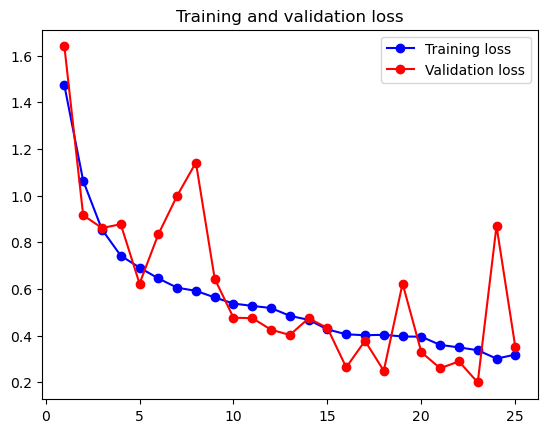

In [5]:
# Xception
checkpoint_filename = "/xception_lr0.001.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "architecture": applications.Xception,

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),

    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline_complex(train_dataset, val_dataset, hyperparameters)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_10 (Flatten)        (None, 2048)              0         
                                                                 
 dense_20 (Dense)            (None, 256)               524544    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 5)                 128

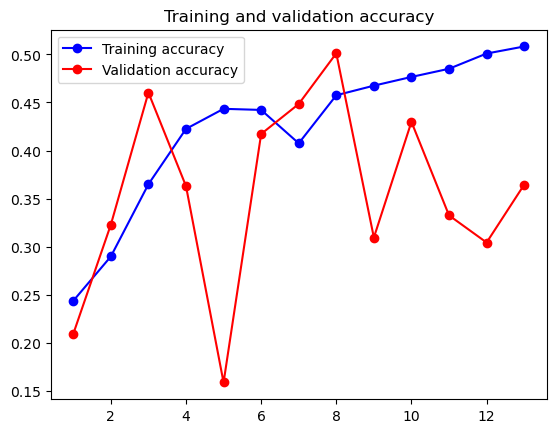

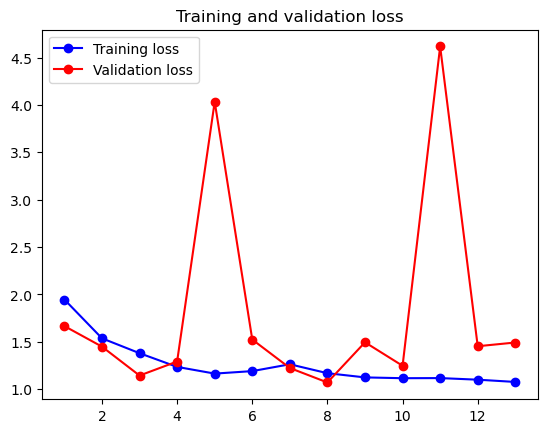

In [20]:
# Residual
checkpoint_filename = "/residual_lr0.001.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "architecture": applications.ResNet50,

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),
    
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline_complex(train_dataset, val_dataset, hyperparameters)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_12 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_13 (Flatten)        (None, 2048)              0         
                                                                 
 dense_26 (Dense)            (None, 256)               524544    
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 5)                 128

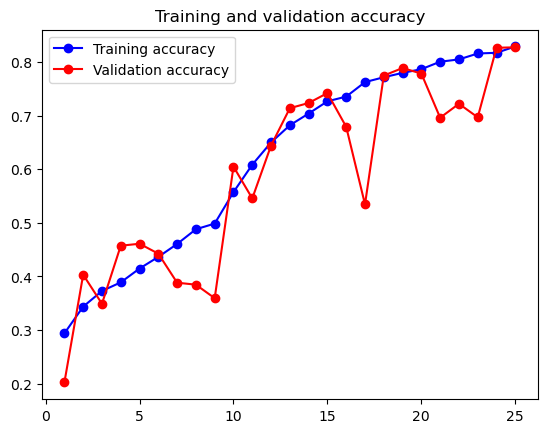

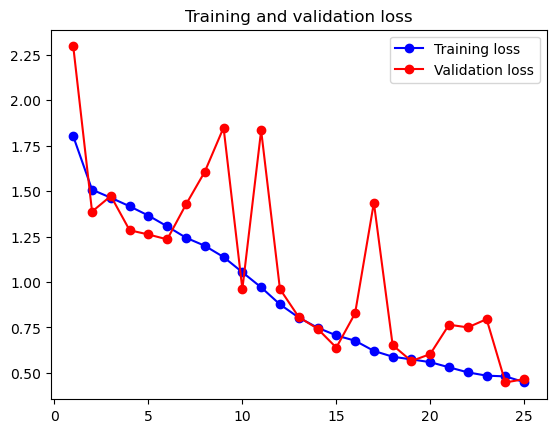

In [23]:
# Residual with lower learning rate
checkpoint_filename = "/residual_lr0.0001.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.0001,
    "optimizer": optimizers.Adam,

    "architecture": applications.ResNet50,

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),
    
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline_complex(train_dataset, val_dataset, hyperparameters)

The training using VGG16 and VGG19 was not succesful. We can attach this problem to the huge complexity of these architectures with respect to our small dataset. They are composed by a large number of parameters and they were originally trained on the **ImageNet** dataset, which contains millions of images across thousands of categories. A small dataset does not provide enough diverse examples for the model to learn robust features and generalize well to unseen data.

For the rest of the models in general the results were quite similar to the ones obtained when training the model from scratch (with a validation accuracy near ~0.8). However, Xception model achieved to reach the 0.9 of validation accuracy.

Note that for Inception and Residual networks we had to repeat the training because of a too high learning rate, similar as a problem occured when training the architecture from scratch.

To end with this section let's now test creating a **wide model using Depthwise separable convolutions**. As always, we first train the baseline model and then we apply regularization techniques.

In [9]:
def create_scratch_wide_model(use_batch_normalization=False, use_dropout=False, regularizer=False, data_augmentation=None):  
  inputs = keras.Input(shape=(180, 180, 3))

  if data_augmentation is not None:
    x = data_augmentation(inputs)
    x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)
  else:
    x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(inputs)

  for size in [32, 64, 128, 256, 512]:
    residual = x

    if use_batch_normalization:
      x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
  
    if use_batch_normalization:
      x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
  
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
  
    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

  x = layers.GlobalAveragePooling2D()(x)

  if (use_dropout):
    x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(5, activation="softmax")(x)

  model = keras.Model(inputs, outputs)

  model.summary()
  
  return model

def train_model(model, train_dataset, val_dataset, epochs=20, lr=0.001, optimizer=keras.optimizers.Adam, checkpoint=None, lr_scheduler=None, early_stop=None):

  model.compile(optimizer=optimizer(learning_rate=lr),
    loss="categorical_crossentropy",
    metrics=["accuracy",keras.metrics.F1Score(),keras.metrics.Precision(),keras.metrics.Recall()]
  )

  callbacks = []
  if checkpoint is not None:
    callbacks.append(checkpoint)
  if lr_scheduler is not None:
    callbacks.append(lr_scheduler)
  if early_stop is not None:
    callbacks.append(early_stop)

  history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks)
  return history

def execute_pipeline(train_dataset, val_dataset, hyperparameters):

  # Set the seed to ensure reproducibility
  keras.utils.set_random_seed(RANDOM_SEED)

  model = create_scratch_wide_model(use_batch_normalization=hyperparameters["bn"], use_dropout=hyperparameters["dropout"], data_augmentation=hyperparameters["augmentation"], regularizer=hyperparameters["regularizer"])
  history = train_model(model, train_dataset, val_dataset, hyperparameters["epochs"],
                        hyperparameters["lr"], hyperparameters["optimizer"],
                        hyperparameters["checkpoint"], hyperparameters["lr_scheduler"], hyperparameters["early_stop"])
  plot(history)

  return model, history

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 176, 176, 32)         2400      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 176, 176, 32)         0         ['conv2d[0][0]']              
                                                                                                  
 separable_conv2d (Separabl  (None, 176, 176, 32)         1312      ['activation[0][0]']          
 eConv2D)                                                                                     

2024-02-28 08:54:28.709679: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-28 08:54:33.766282: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9729a93310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-28 08:54:33.766315: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-02-28 08:54:33.778649: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709106873.883484    3259 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


379/379 [==============================] - 55s 97ms/step - loss: 1.5470 - accuracy: 0.3008 - f1_score: 0.2913 - precision: 0.4838 - recall: 0.0172 - val_loss: 1.5439 - val_accuracy: 0.3170 - val_f1_score: 0.2820 - val_precision: 0.4516 - val_recall: 0.0208
Epoch 2/25
379/379 [==============================] - 29s 74ms/step - loss: 1.3126 - accuracy: 0.4446 - f1_score: 0.4422 - precision: 0.6046 - recall: 0.1682 - val_loss: 1.0308 - val_accuracy: 0.5657 - val_f1_score: 0.5525 - val_precision: 0.6348 - val_recall: 0.4439
Epoch 3/25
379/379 [==============================] - 28s 74ms/step - loss: 0.9037 - accuracy: 0.6292 - f1_score: 0.6275 - precision: 0.7150 - recall: 0.4762 - val_loss: 0.7669 - val_accuracy: 0.7053 - val_f1_score: 0.7073 - val_precision: 0.7749 - val_recall: 0.5828
Epoch 4/25
379/379 [==============================] - 34s 88ms/step - loss: 0.7309 - accuracy: 0.7031 - f1_score: 0.7017 - precision: 0.7766 - recall: 0.6068 - val_loss: 0.6557 - val_accuracy: 0.7365 - val_f

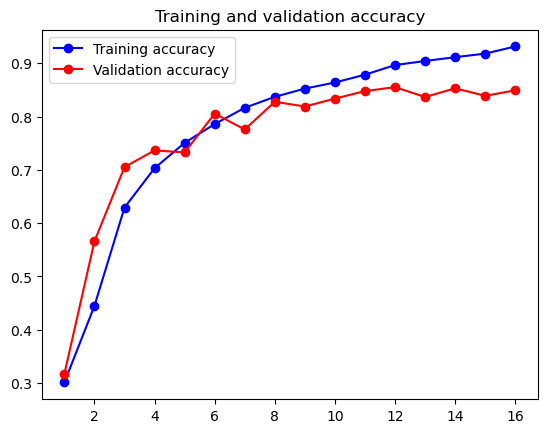

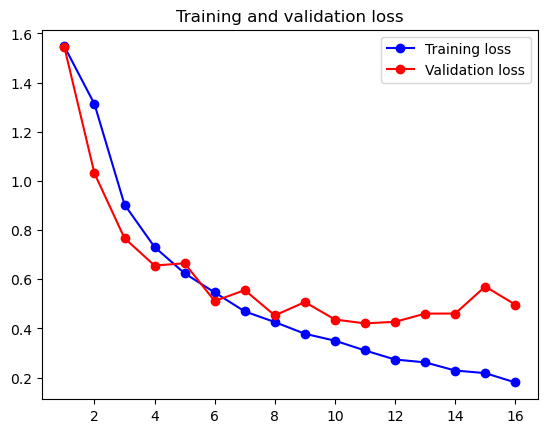

In [6]:
# Scratch wide model
checkpoint_filename = "/cnn_wide_lr0.001.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "bn": False,
    "regularizer": None,
    "dropout": False,
    "augmentation": None,
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 augmentation (Sequential)   (None, 180, 180, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv2d_6 (Conv2D)           (None, 176, 176, 32)         2400      ['augmentation[0][0]']        
                                                                                                  
 activation_10 (Activation)  (None, 176, 176, 32)         0         ['conv2d_6[0][0]']            
                                                                                            

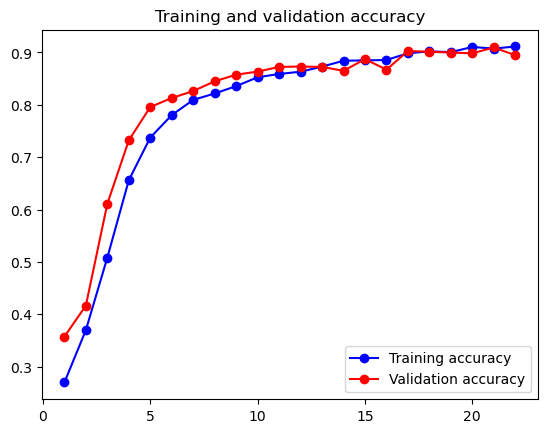

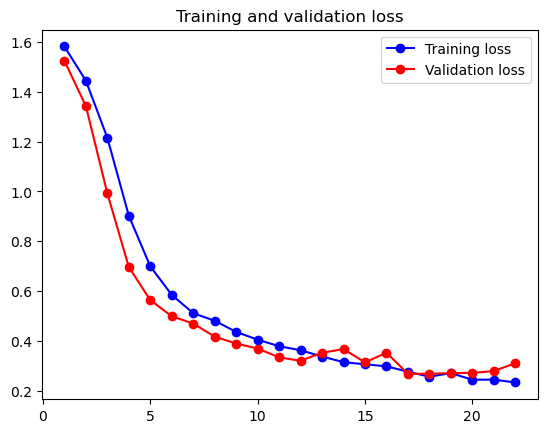

In [7]:
# Scratch wide model with data augmentation
checkpoint_filename = "/cnn_wide_lr0.001_da.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "bn": False,
    "regularizer": None,
    "dropout": False,
    "augmentation": keras.Sequential(
      [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
      ], name="augmentation"),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 augmentation (Sequential)   (None, 180, 180, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv2d_211 (Conv2D)         (None, 176, 176, 32)         2400      ['augmentation[0][0]']        
                                                                                                  
 activation_203 (Activation  (None, 176, 176, 32)         0         ['conv2d_211[0][0]']          
 )                                                                                          

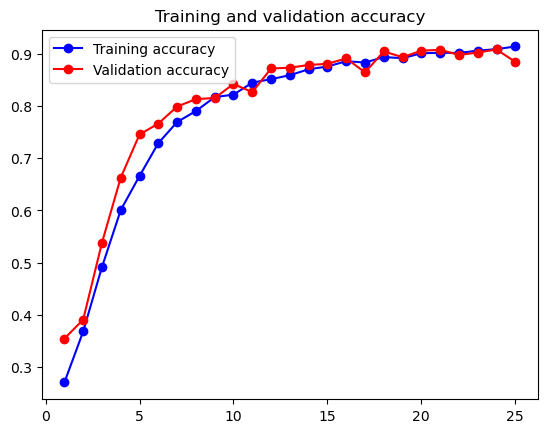

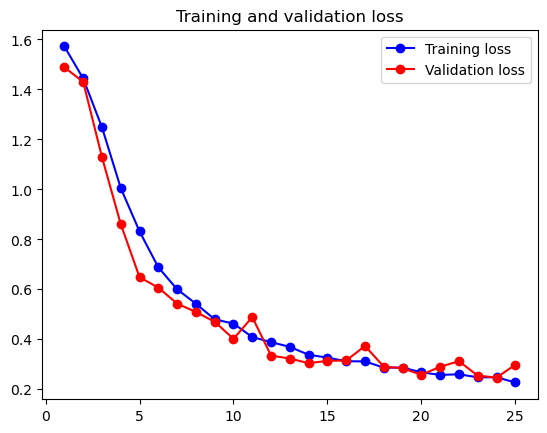

In [10]:
# Scratch wide model with data augmentation and dropout
checkpoint_filename = "/cnn_wide_lr0.001_dropout_da.keras"
hyperparameters = {
    "epochs": 25,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "bn": False,
    "regularizer": None,
    "dropout": True,
    "augmentation": keras.Sequential(
      [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
      ], name="augmentation"),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(train_dataset, val_dataset, hyperparameters)

The baseline networks started to overfit in epoch 11 so we deciced to try the model adding dropout and data augmentation, since they demonstrated more appropiate evolution of the curves. Both techniques improved considerable the results (from 0.8 to 0.9 of validation accuracy) and adjusted training and validation curves almost perfectly. These results highlight the **potential** of Depthwise separable convolution since with significantly fewer parameters and fewer computations compared to regular convolution, obtain comparable representational power. This results in smaller models that converge faster and are less prone to overfitting which is especially important when training small models from scratch on limited data, as in this problem.

## 3. Pretrained models.

Three pre-trained model architectures have been considered for applying transfer learning: **VGG16, VGG19 and the best convolutional model trained from scratch** in the previous section. These architectures were pre-trained on the **ImageNet** dataset (1.4 million labeled images and 1,000 different classes), which contains many animal classes and we can thus expect it to perform well on our problem. We will follow two different transfer learning paradigms trying to maximize the performance of those models: **feature extraction** and **fine-tuning**.

### Feature extraction strategy

Feature extraction consists of using the representations learned by a previously trained model to extract interesting features from new samples. We freeze the weights in the feature extraction layer so they don't change in the new training process. These features are then run through a new classifier, which is trained from scratch.

Our classificator module will be composed by **1 hidden layer with 1024 units**. We will test first the baseline models and then we will apply several modifications or regularization trying to improve the model performance if required.

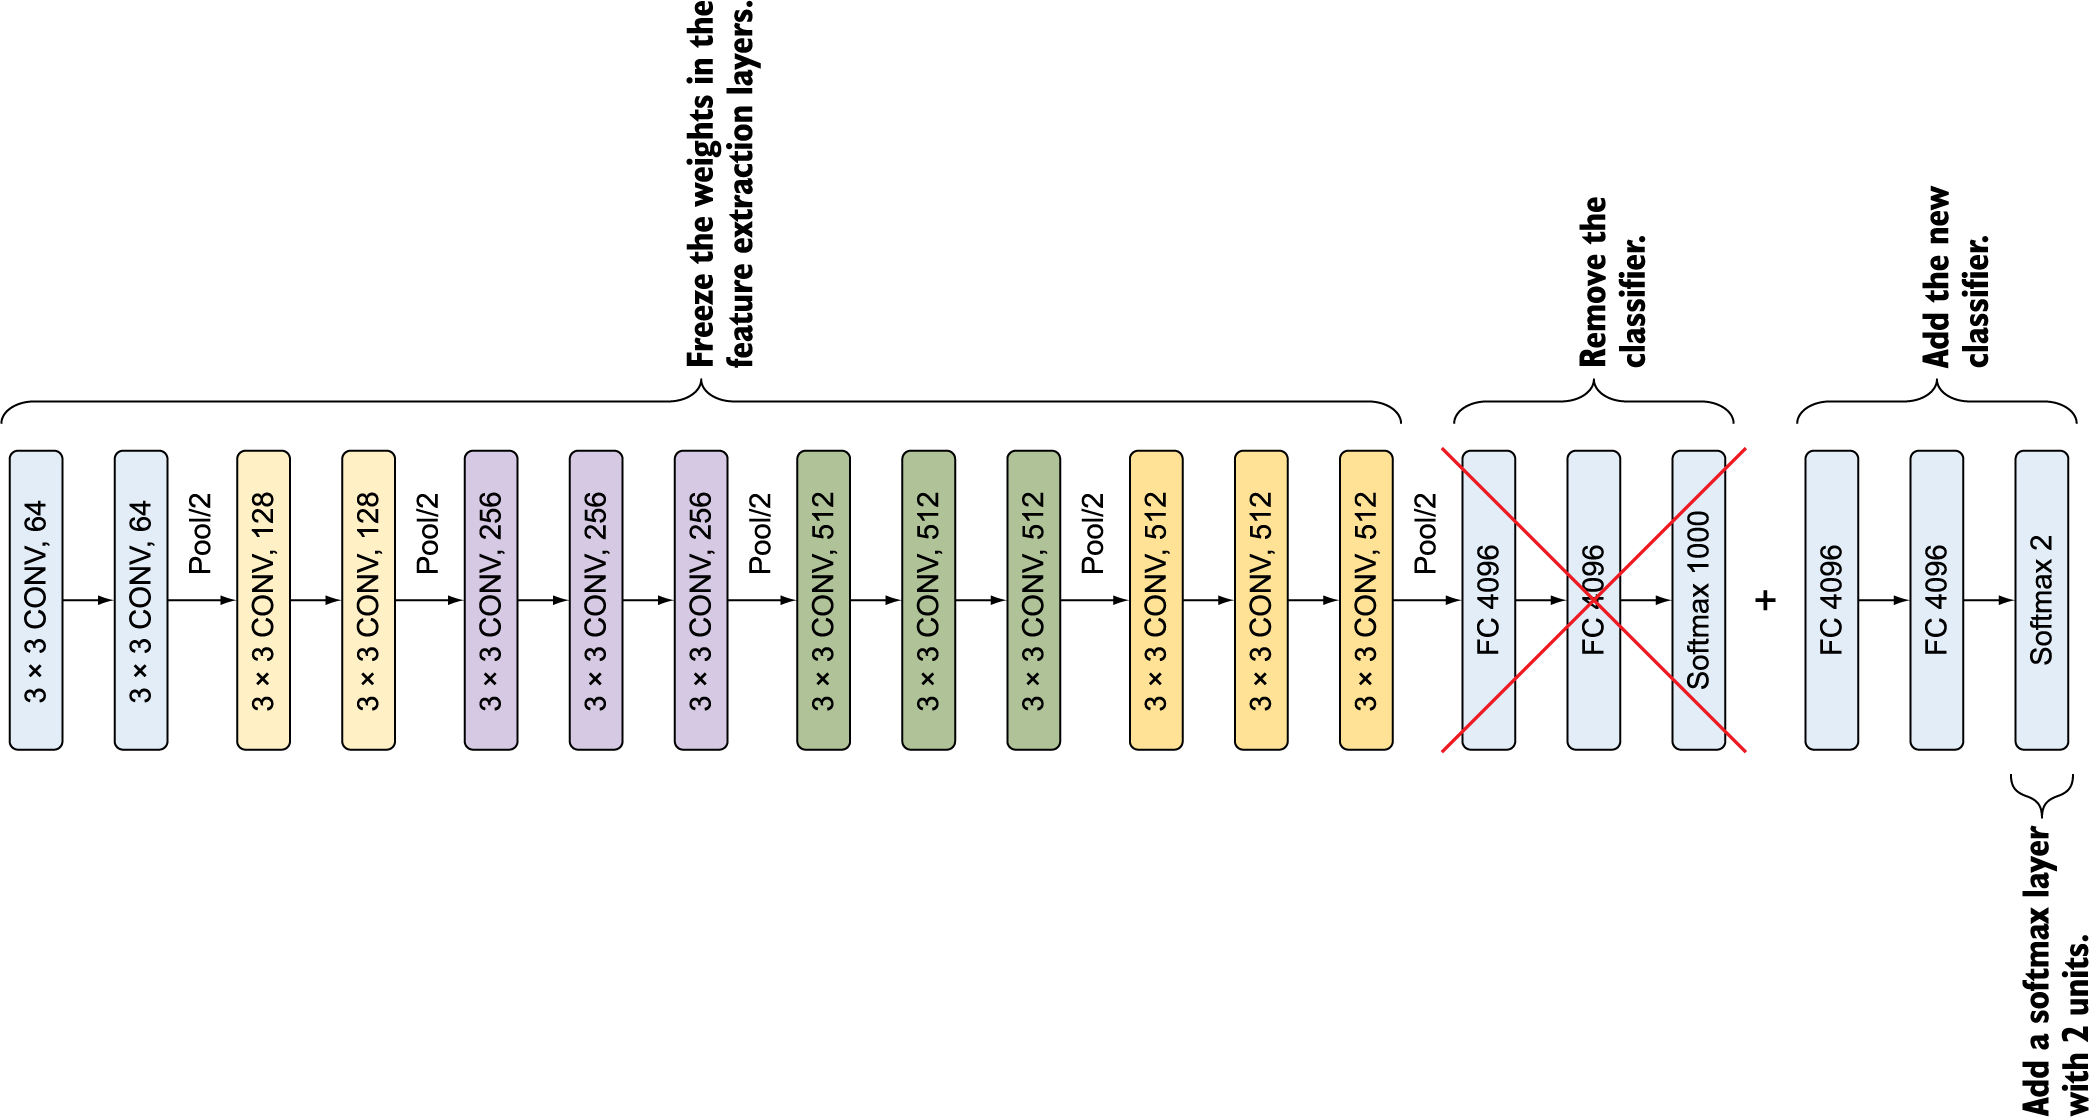

#### Define functions

In [11]:
def train_model(model, train_dataset, val_dataset, epochs=20, lr=0.001, optimizer=keras.optimizers.Adam, checkpoint=None, lr_scheduler=None, early_stop=None):

  model.compile(optimizer=optimizer(learning_rate=lr),
    loss="categorical_crossentropy",
    metrics=["accuracy",keras.metrics.F1Score(),keras.metrics.Precision(),keras.metrics.Recall()]
  )

  callbacks = []
  if checkpoint is not None:
    callbacks.append(checkpoint)
  if lr_scheduler is not None:
    callbacks.append(lr_scheduler)
  if early_stop is not None:
    callbacks.append(early_stop)

  history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks)
  return history

def create_transfer_learning_model(cnn_model, dropout=False, data_augmentation=None):

  inputs = keras.Input(shape=(180, 180, 3))
  x = None

  if data_augmentation is not None:
    x = data_augmentation(inputs)

  # Convolutional layers
  cnn_model.trainable = False
  if x is None:
    x = cnn_model(inputs)
  else:
    x = cnn_model(x)

  x = layers.Flatten()(x)
  
  # Replace the whole classificator module since they are different problems
  x = layers.Dense(1024, activation="relu")(x)
  if (dropout):
    x = layers.Dropout(0.25)(x)
  outputs = layers.Dense(5, activation="softmax")(x)

  new_model = keras.Model(inputs, outputs)
  new_model.summary()

  return new_model

def prepare_fine_tuning(model, n_fine_tuned_layers, dropout=False):
  model.trainable = True

  # Layers to fine tune
  for layer in model.layers[:-(2+dropout+n_fine_tuned_layers)]:
    layer.trainable = False

def execute_pipeline(cnn_model, train_dataset, val_dataset, hyperparameters):

  # Set the seed to allow reproducibility
  keras.utils.set_random_seed(RANDOM_SEED)

  # Feature extraction
  model = create_transfer_learning_model(cnn_model, dropout=hyperparameters["dropout"], data_augmentation=hyperparameters["data_augmentation"])
  history = train_model(model, train_dataset, val_dataset, hyperparameters["epochs"],
                        hyperparameters["lr"], hyperparameters["optimizer"],
                        hyperparameters["checkpoint"], hyperparameters["lr_scheduler"], hyperparameters["early_stop"])
  plot(history)

  # Fine-tuning
  if(hyperparameters["n_fine_tuned_layers"] > 0):
    prepare_fine_tuning(model,hyperparameters["n_fine_tuned_layers"],dropout=hyperparameters["dropout"])
    history = train_model(model, train_dataset, val_dataset, hyperparameters["epochs"],
                        hyperparameters["fn_lr"], hyperparameters["optimizer"],
                        hyperparameters["checkpoint"], hyperparameters["lr_scheduler"], hyperparameters["early_stop"])
    plot(history)

  return model, history

#### Train models

First, let's analyze what happens when we use VGG16 with our predefined classificator module.

In [12]:
# Instantiating the VGG16 convolutional base
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

In [43]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 1024)              13108224  
                                                                 
 dense_1 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 27828037 (106.16 MB)
Trainable params: 13113349 (50.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/50


2024-02-23 18:17:58.161910: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-23 18:18:02.039417: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb9080b9ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-23 18:18:02.039453: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-02-23 18:18:02.051939: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708708682.157232    2520 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


379/379 [==============================] - 58s 137ms/step - loss: 0.5330 - accuracy: 0.8514 - f1_score: 0.8518 - precision: 0.8672 - recall: 0.8362 - val_loss: 0.2509 - val_accuracy: 0.8968 - val_f1_score: 0.8979 - val_precision: 0.9133 - val_recall: 0.8842
Epoch 2/50
379/379 [==============================] - 51s 133ms/step - loss: 0.1979 - accuracy: 0.9249 - f1_score: 0.9251 - precision: 0.9328 - recall: 0.9175 - val_loss: 0.2365 - val_accuracy: 0.9050 - val_f1_score: 0.9056 - val_precision: 0.9200 - val_recall: 0.8968
Epoch 3/50
379/379 [==============================] - 51s 134ms/step - loss: 0.1263 - accuracy: 0.9538 - f1_score: 0.9540 - precision: 0.9576 - recall: 0.9486 - val_loss: 0.2610 - val_accuracy: 0.9050 - val_f1_score: 0.9055 - val_precision: 0.9107 - val_recall: 0.9013
Epoch 4/50
379/379 [==============================] - 51s 133ms/step - loss: 0.0998 - accuracy: 0.9618 - f1_score: 0.9620 - precision: 0.9661 - recall: 0.9593 - val_loss: 0.2992 - val_accuracy: 0.9027 - v

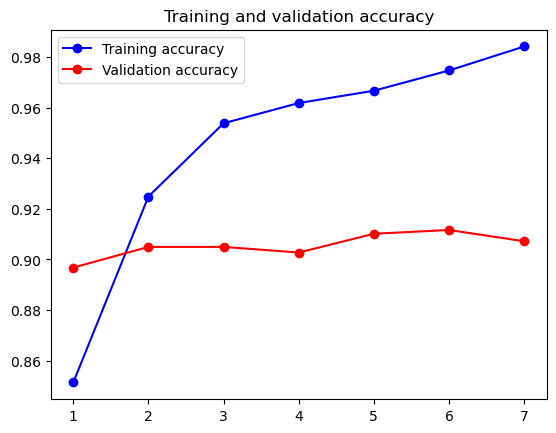

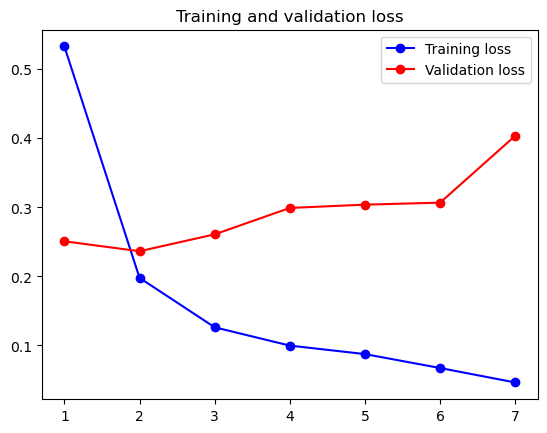

In [6]:
# Baseline model (VGG16)
# Instantiating the VGG16 convolutional base
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

checkpoint_filename = "/VGG16_feature_extraction.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": keras.optimizers.Adam,

    "n_fine_tuned_layers": 0,  # apart from the Denses, starting from the bottom of the network

    "dropout":False,
    "data_augmentation": None,
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(conv_base, train_dataset, val_dataset, hyperparameters)

The baseline model is a really good starting point since it provides very good results (validation accuracy: 0.9117) overcoming our previous model defined from scratch. However the training is stopped soon because the network starts to overfit in epoch 3. Let's try now to reduce the overfitting problem using **dropout** and **data augmentation**.

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              13108224  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 5)                 5125

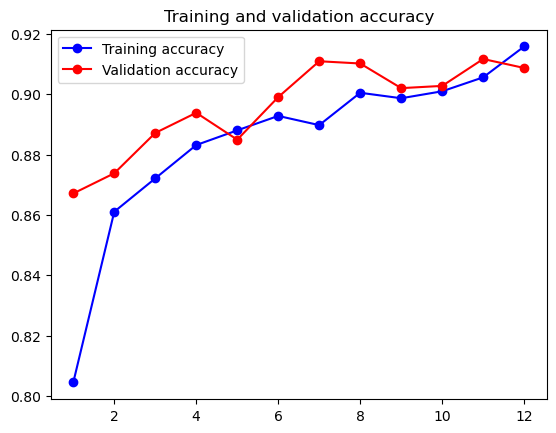

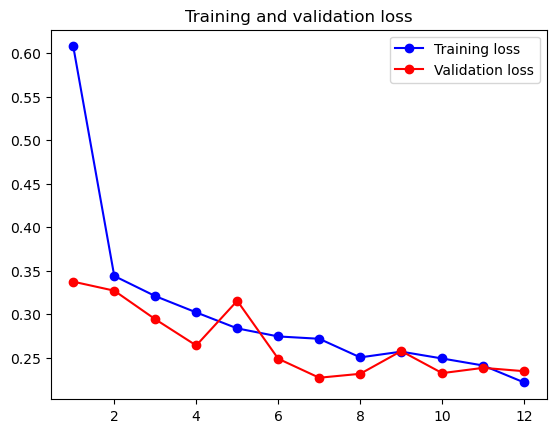

In [7]:
# VGG16 (dropout + augmentation)
# Instantiating the VGG16 convolutional base
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

checkpoint_filename = "/VGG16_feature_extraction_dropout.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "n_fine_tuned_layers": 0,  # apart from the Denses, starting from the bottom of the network

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(conv_base, train_dataset, val_dataset, hyperparameters)

Now we can see that the overfitting problem has been highly reduced since the validation loss keeps almost horizontal. Nevertheless, we can observe some peaks derived from a high learning rate value, so let's use again the learning rate scheduler to reduce this problem and train again.

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 12800)             0         
                                                                 
 dense_30 (Dense)            (None, 1024)              13108224  
                                                                 
 dropout_19 (Dropout)        (None, 1024)              0         
                                                                 
 dense_31 (Dense)            (None, 5)                 5125

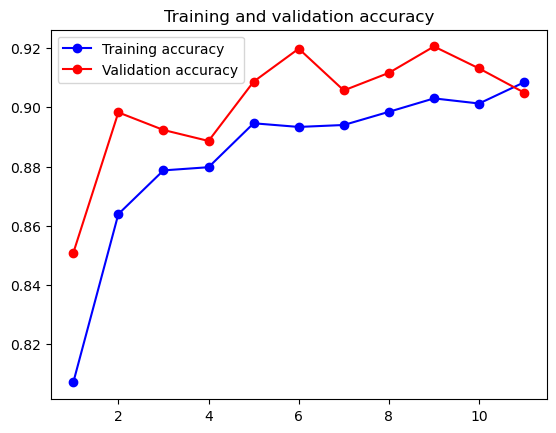

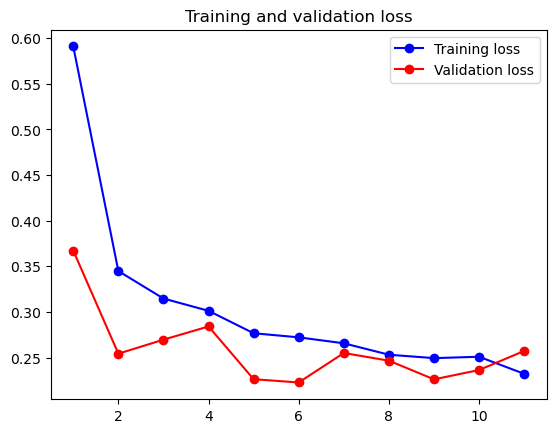

In [21]:
# VGG16 (dropout + augmentation + lr_scheduler)
# Instantiating the VGG16 convolutional base
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

checkpoint_filename = "/VGG16_feature_extraction_dropout_lrScheduler.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "n_fine_tuned_layers": 0,  # apart from the Denses, starting from the bottom of the network

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),
    "lr_scheduler": keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr if epoch < 20 else lr * tf.math.exp(-0.1)),
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(conv_base, train_dataset, val_dataset, hyperparameters)

Now it is the turn to test VGG19. We will analyze both the baseline model and the best regularization configuration obtained for VGG16.

80134624/80134624 [==============================] - 6s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 12800)             0         
                                                                 
 dense_4 (Dense)             (None, 1024)              13108224  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                            

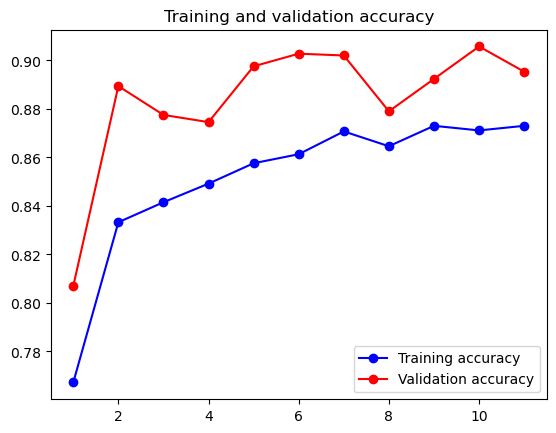

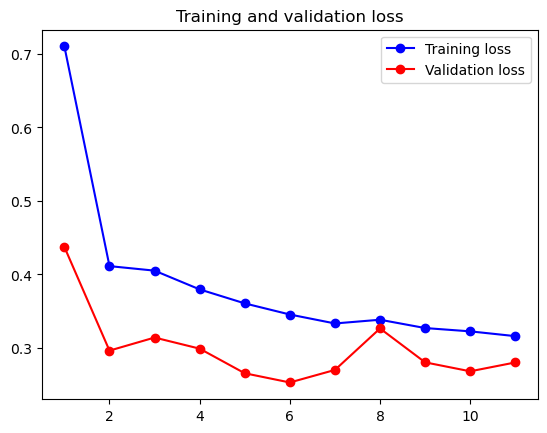

In [8]:
# VGG19 (dropout + augmentation)
# Instantiating the VGG19 convolutional base
conv_base = keras.applications.vgg19.VGG19(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

checkpoint_filename = "/VGG19_feature_extraction_dropout.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "n_fine_tuned_layers": 0,  # apart from the Denses, starting from the bottom of the network

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(conv_base, train_dataset, val_dataset, hyperparameters)

83683744/83683744 [==============================] - 5s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              75498496  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                            

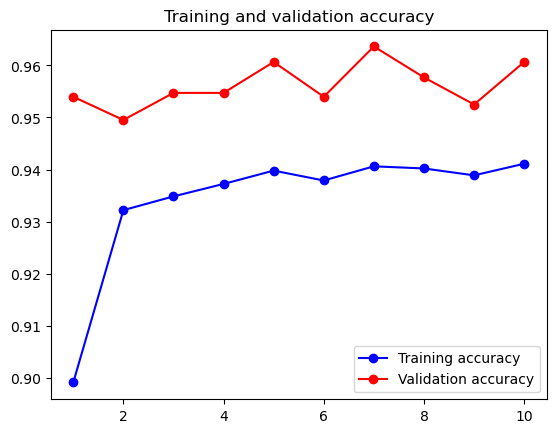

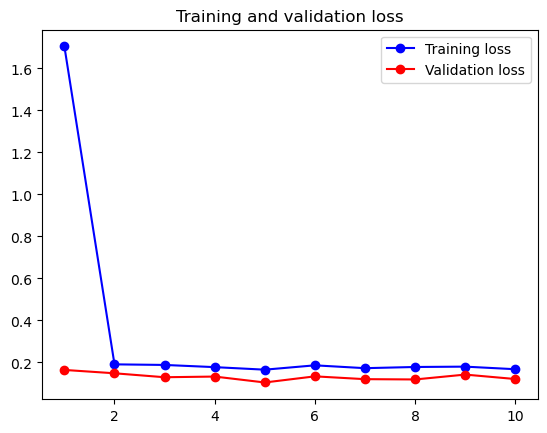

In [10]:
# Xception (dropout + augmentation)
# Instantiating the Xception convolutional base
conv_base = keras.applications.Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

checkpoint_filename = "/Xception_feature_extraction_dropout.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "n_fine_tuned_layers": 0,  # apart from the Denses, starting from the bottom of the network

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(conv_base, train_dataset, val_dataset, hyperparameters)

87910968/87910968 [==============================] - 4s 0us/step
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_5 (Dense)             (None, 1024)              33555456  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                            

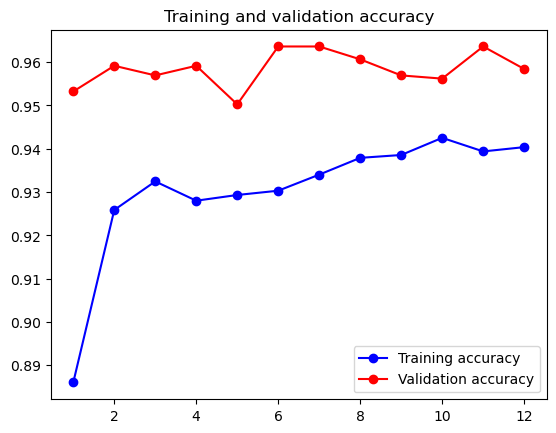

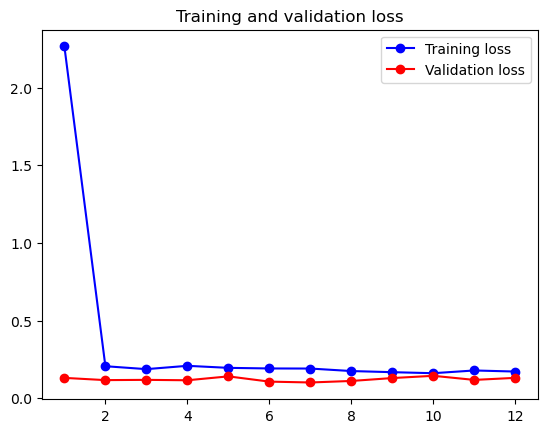

In [11]:
# InceptionV3 (dropout + augmentation)
# Instantiating the InceptionV3 convolutional base
conv_base = keras.applications.InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

checkpoint_filename = "/InceptionV3_feature_extraction_dropout.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "n_fine_tuned_layers": 0,  # apart from the Denses, starting from the bottom of the network

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(conv_base, train_dataset, val_dataset, hyperparameters)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 inception_resnet_v2 (Funct  (None, 4, 4, 1536)        54336736  
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 24576)             0         
                                                                 
 dense_5 (Dense)             (None, 1024)              25166848  
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                           

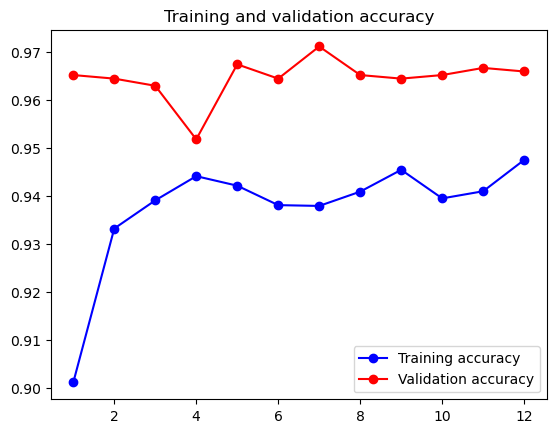

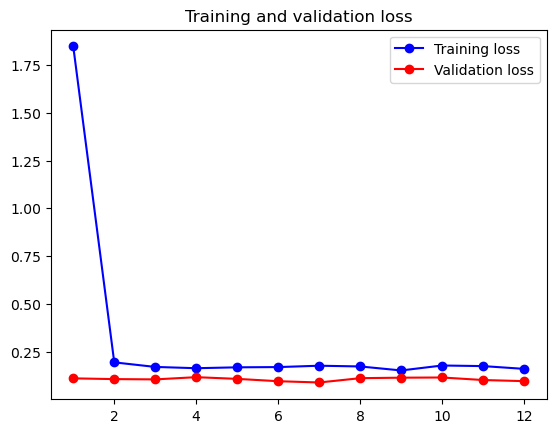

In [13]:
# InceptionResNetV2 (dropout + augmentation)
# Instantiating the InceptionResNetV2 convolutional base
conv_base = keras.applications.InceptionResNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

checkpoint_filename = "/InceptionResNetV2_feature_extraction_dropout.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "n_fine_tuned_layers": 0,  # apart from the Denses, starting from the bottom of the network

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(conv_base, train_dataset, val_dataset, hyperparameters)

**EXPERIMENT**: Just with experimental purposes we will try to use the best model trained from scratch in the previous section and we will apply feature extraction. Since it was trained with the same dataset the convolutional block already knows the existing patterns on our data so let's see what happens if we just change the classification block of the model.

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 model_1 (Functional)        (None, 5)                 3095749   
                                                                 
 flatten_4 (Flatten)         (None, 5)                 0         
                                                                 
 dense_12 (Dense)            (None, 1024)              6144      
                                                                 
 dense_13 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 3107018 (11.85 MB)
Trainable params: 11269 (44.02 KB)
Non-trainable params: 3095749 (11.81 MB)
_________________________________________________________________
Epoch 1/50
379/3

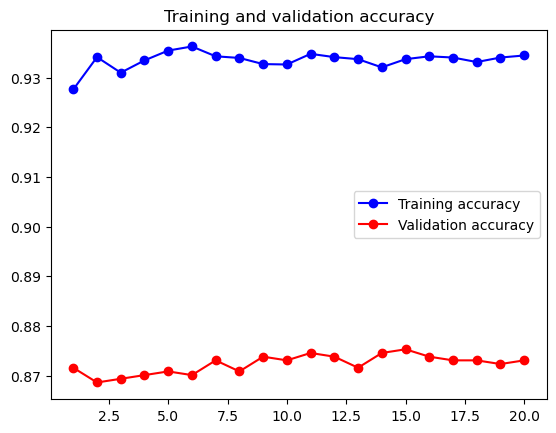

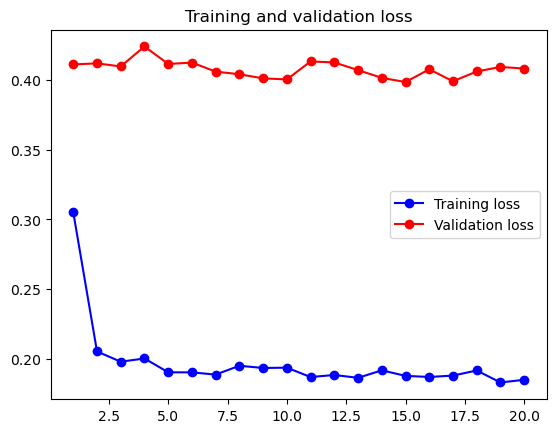

In [20]:
# Best scratch model
conv_base = keras.models.load_model(
    OUT_MODELS_FOLDER + "/cnn_reg_lr0.0005_dropout_aug_lrScheduler.keras")

checkpoint_filename = "/VGG16_feature_extraction_dropout.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.Adam,

    "n_fine_tuned_layers": 0,  # apart from the Denses, starting from the bottom of the network

    "dropout":False,
    "data_augmentation": None,
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(conv_base, train_dataset, val_dataset, hyperparameters)

It is interesting to see that the loss curve remains constant across epochs, except for the first two epochs, due to the feature extraction block had already learned features specific to the dataset during the initial training (recall that the convolutional base is by far the most expensive part of the pipeline). However, it is always a good practice to experiment with different approaches and evaluate their performance empirically. Sometimes, even if the initial features learned during pre-training overlap with the dataset, fine-tuning certain layers or adapting the network's architecture can still lead to improvements in performance, but this is not the case as the performance remains the same.

### Fine-tuning

Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction. Then jointly train both these top layers and the added part (the fully connected classifier). It slightly adjusts the more abstract features reused in order to make them more relevant for the problem at hand.

Same as before, our classificator module will be composed by **1 hidden layer with 1024 units**. The steps for fine-tuning a network are as follows:

1. Add our custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part we added.

* This are the same steps as in feature extraction:
    * We need to train the classifier part before fine-tuning.
    * Otherwise the error signal during training will be too large and it will destroy the features already learned in the layer we are going to fine-tune.

4. Unfreeze some layers in the base network. 
5. Jointly train both those layers and the classifier added (again).

We will test first the baseline models and then we will apply several modifications or regularization trying to improve the model performance if required.

Let's start doing a **fine-tuning of the last block** of the convolutional model. It is important to recall that fine-tuning requires a low learning rate.
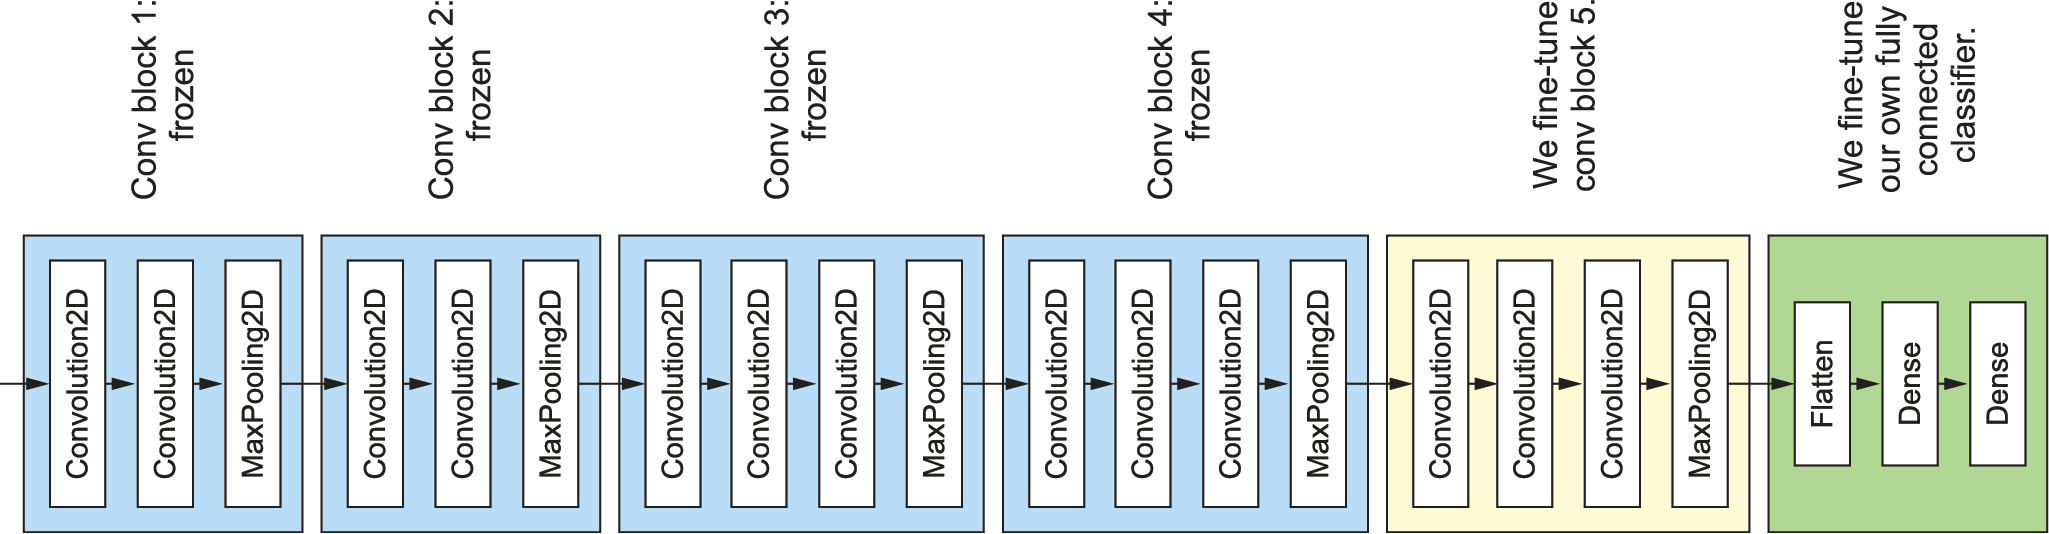

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              13108224  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 27828037 (106.16 MB)
Trainable params: 201927

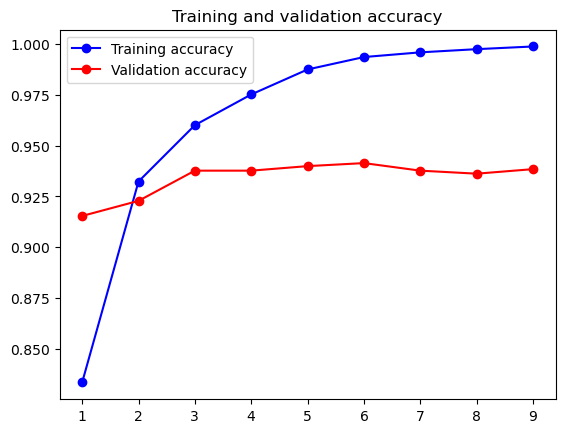

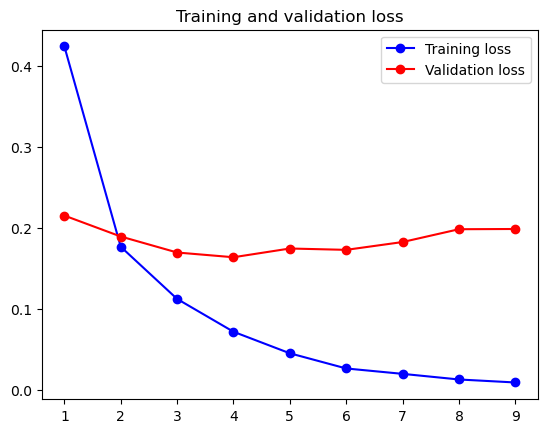

In [7]:
# VGG16 fine-tuning the last layer (dropout)
# Instantiating the VGG16 convolutional base
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

checkpoint_filename = "/VGG16_finetuning_dropout.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 1e-5, # We’ll use a very low learning rate when fine-tuning our model.
    "optimizer": optimizers.Adam,

    "n_fine_tuned_layers": 4,  # apart from the Denses, starting from the bottom of the network

    "dropout":True,
    "data_augmentation": None,
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(conv_base, train_dataset, val_dataset, hyperparameters)

At a first glance, we can see that the validation results are really good, with a validation accuracy of 0.9414. In addition, the model does not seem to be suffering from an important overfitting, since the slope of the loss curve is almost horizontal, but let's try what happens when we apply regularization. We will use dropout together with data augmentation and we will test 2 different options of fine-tuning (taking either 1 or 2 convolutional blocks).

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0         
                                                                 
 dense_8 (Dense)             (None, 1024)              13108224  
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 5)                 5125

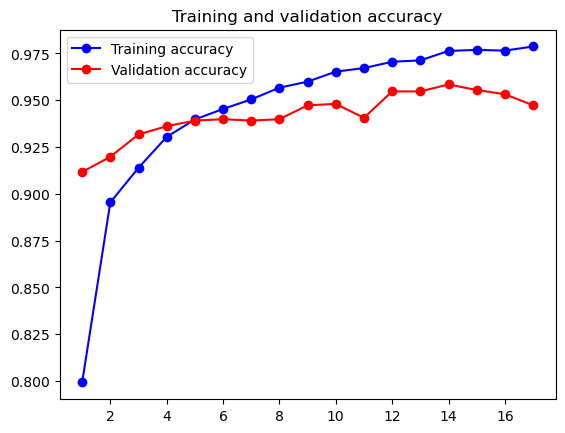

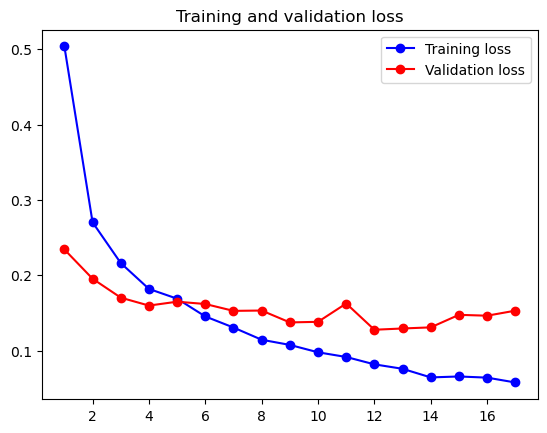

In [11]:
# VGG16 fine-tuning the last layer (dropout + data augmentation)
# Instantiating the VGG16 convolutional base
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

checkpoint_filename = "/VGG16_finetuning_dropout_da.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "fn_lr": 1e-5, # We’ll use a very low learning rate when fine-tuning our model.
    "optimizer": optimizers.Adam,

    "n_fine_tuned_layers": 4,  # apart from the Denses, starting from the bottom of the network

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(conv_base, train_dataset, val_dataset, hyperparameters)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              13108224  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 5)                 5125

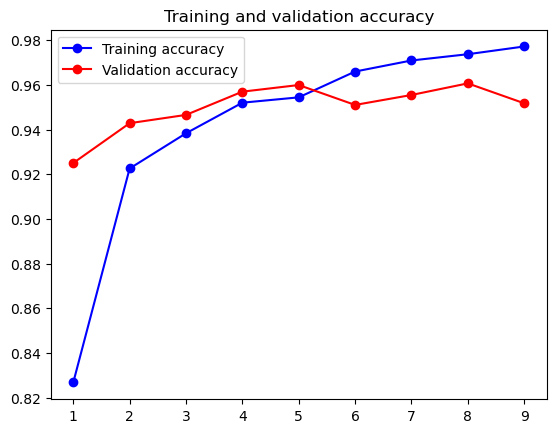

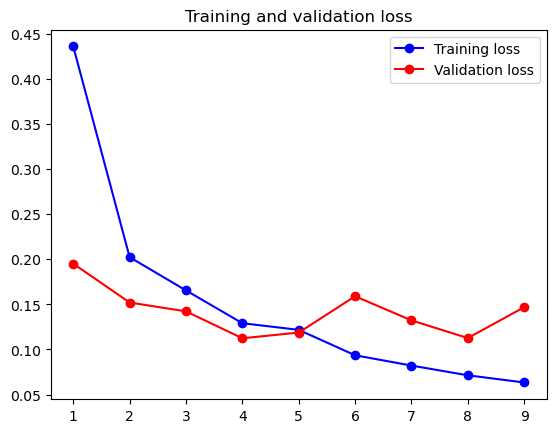

In [9]:
# VGG16 fine-tuning the two last layers (dropout + data augmentation)
# Instantiating the VGG16 convolutional base
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

checkpoint_filename = "/VGG16_finetuning2_dropout_da.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "fn_lr": 1e-5, # We’ll use a very low learning rate when fine-tuning our model.
    "optimizer": optimizers.Adam,

    "n_fine_tuned_layers": 8,  # apart from the Denses, starting from the bottom of the network

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(conv_base, train_dataset, val_dataset, hyperparameters)

From the plots of the 1-block fine-tuning we can see how the application of regularization achieves to delay the overfiting emergence until epoch 12 and improve the validation accuracy (from 0.9414 to 0.9584). 

Regarding 2-block fine-tuning we achieve to overcome these results and obtain an impressive performance with a validation accuracy of 0.9607, the best found until now.

Now it is the turn to analyze VGG19. We will apply regularization techniques as they have helped to improve the performance of VGG16 and we will test again 2 different options of fine-tuning (taking either 1 or 2 convolutional blocks).

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0         
                                                                 
 dense_8 (Dense)             (None, 1024)              13108224  
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 5)                 5125

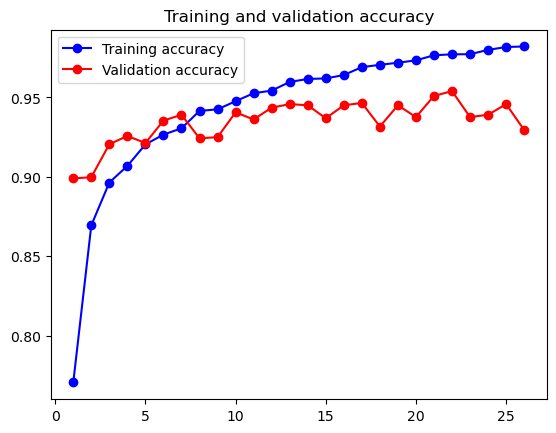

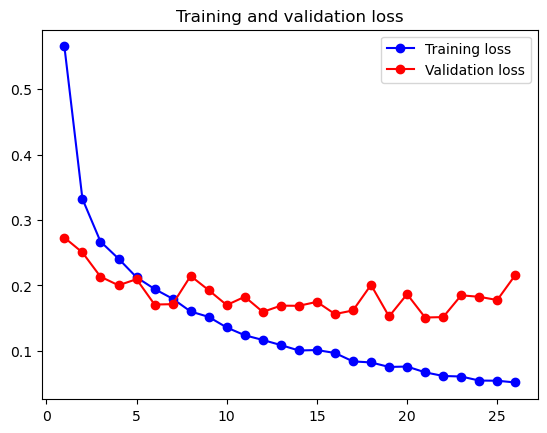

In [10]:
# VGG19 fine-tuning the last layer (dropout + data augmentation)
# Instantiating the VGG16 convolutional base
conv_base = keras.applications.vgg19.VGG19(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

checkpoint_filename = "/VGG19_finetuning_dropout_da.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "fn_lr": 1e-5, # We’ll use a very low learning rate when fine-tuning our model.
    "optimizer": optimizers.Adam,

    "n_fine_tuned_layers": 4,  # apart from the Denses, starting from the bottom of the network

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(conv_base, train_dataset, val_dataset, hyperparameters)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 flatten_5 (Flatten)         (None, 12800)             0         
                                                                 
 dense_10 (Dense)            (None, 1024)              13108224  
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_11 (Dense)            (None, 5)                 5125

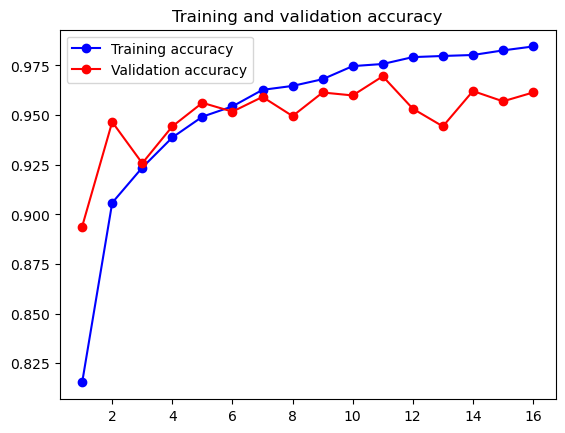

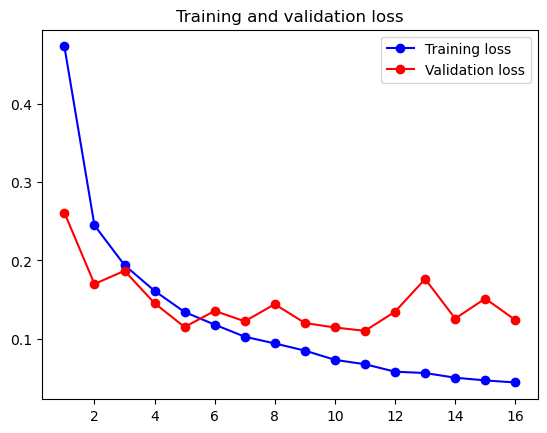

In [11]:
# VGG19 fine-tuning the two last layers (dropout + data augmentation)
# Instantiating the VGG19 convolutional base
conv_base = keras.applications.vgg19.VGG19(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

checkpoint_filename = "/VGG19_finetuning2_dropout_da.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "fn_lr": 1e-5, # We’ll use a very low learning rate when fine-tuning our model.
    "optimizer": optimizers.Adam,

    "n_fine_tuned_layers": 8,  # apart from the Denses, starting from the bottom of the network

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(conv_base, train_dataset, val_dataset, hyperparameters)

Again fine-tuning 2 convolutional blocks provided the best results with a validation accuracy of 0.9696. Thus the best model obtained using the fine-tuning technique was **VGG19 fine-tuning 2 convolutional blocks with dropout and data augmentation**.

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 flatten_4 (Flatten)         (None, 73728)             0         
                                                                 
 dense_9 (Dense)             (None, 1024)              75498496  
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 5)                 5125

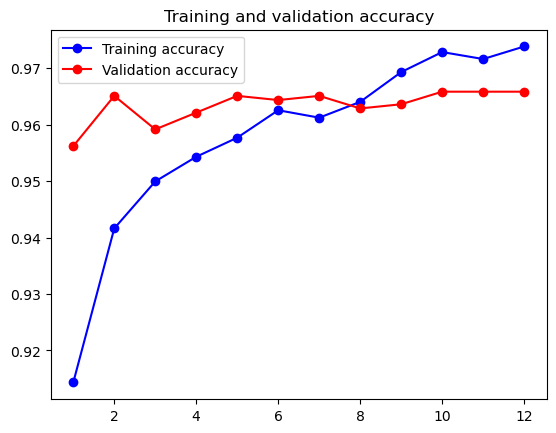

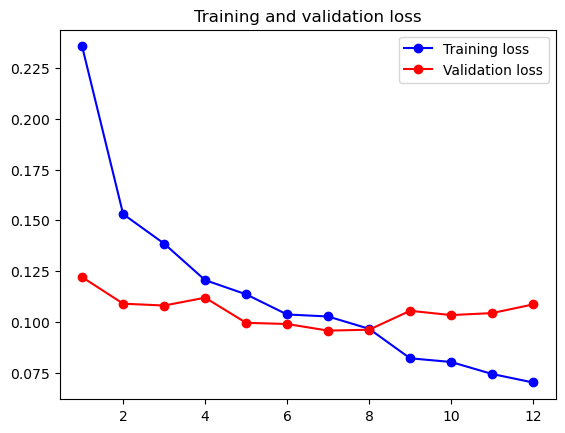

In [15]:
# Xception fine-tuning the last layer (dropout + data augmentation)
# Instantiating the Xception convolutional base
conv_base = keras.applications.Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

checkpoint_filename = "/Xception_finetuning_dropout_da.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "fn_lr": 1e-5, # We’ll use a very low learning rate when fine-tuning our model.
    "optimizer": optimizers.Adam,

    "n_fine_tuned_layers": 4,  # apart from the Denses, starting from the bottom of the network

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(conv_base, train_dataset, val_dataset, hyperparameters)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 flatten_4 (Flatten)         (None, 73728)             0         
                                                                 
 dense_11 (Dense)            (None, 1024)              75498496  
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_12 (Dense)            (None, 5)                 5125

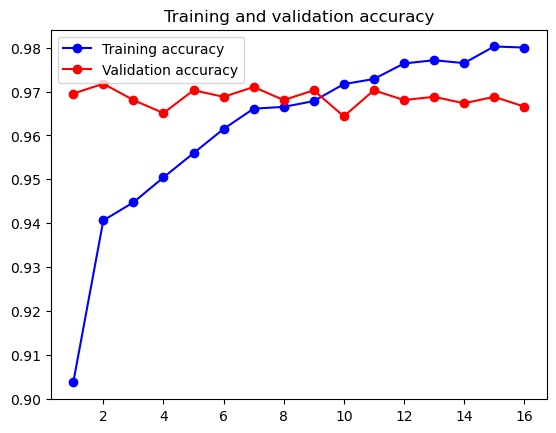

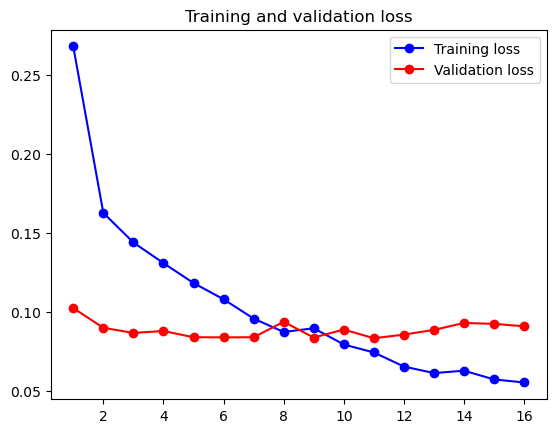

In [14]:
# Xception fine-tuning the two last layers (dropout + data augmentation)
# Instantiating the Xception convolutional base
conv_base = keras.applications.Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

checkpoint_filename = "/Xception_finetuning2_dropout_da.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "fn_lr": 1e-5, # We’ll use a very low learning rate when fine-tuning our model.
    "optimizer": optimizers.Adam,

    "n_fine_tuned_layers": 8,  # apart from the Denses, starting from the bottom of the network

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(conv_base, train_dataset, val_dataset, hyperparameters)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0         
                                                                 
 dense_13 (Dense)            (None, 1024)              33555456  
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_14 (Dense)            (None, 5)                 5125

379/379 [==============================] - 23s 60ms/step - loss: 0.1888 - accuracy: 0.9334 - f1_score: 0.9335 - precision_8: 0.9401 - recall_8: 0.9278 - val_loss: 0.1032 - val_accuracy: 0.9636 - val_f1_score: 0.9642 - val_precision_8: 0.9700 - val_recall_8: 0.9592
Epoch 3/50
379/379 [==============================] - 23s 60ms/step - loss: 0.1645 - accuracy: 0.9381 - f1_score: 0.9382 - precision_8: 0.9463 - recall_8: 0.9336 - val_loss: 0.1030 - val_accuracy: 0.9607 - val_f1_score: 0.9613 - val_precision_8: 0.9641 - val_recall_8: 0.9562
Epoch 4/50
379/379 [==============================] - 23s 60ms/step - loss: 0.1432 - accuracy: 0.9466 - f1_score: 0.9467 - precision_8: 0.9510 - recall_8: 0.9421 - val_loss: 0.0996 - val_accuracy: 0.9599 - val_f1_score: 0.9606 - val_precision_8: 0.9634 - val_recall_8: 0.9577
Epoch 5/50
379/379 [==============================] - 23s 60ms/step - loss: 0.1369 - accuracy: 0.9481 - f1_score: 0.9483 - precision_8: 0.9541 - recall_8: 0.9439 - val_loss: 0.1148 - 

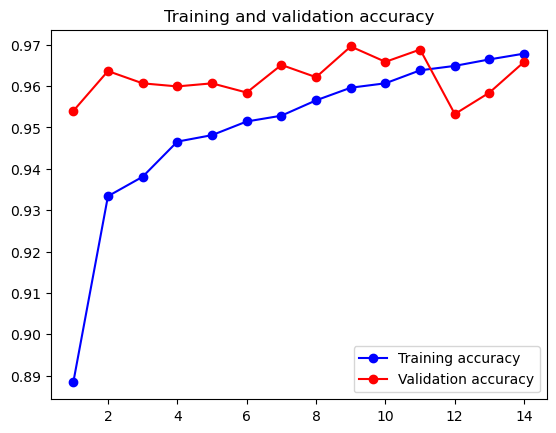

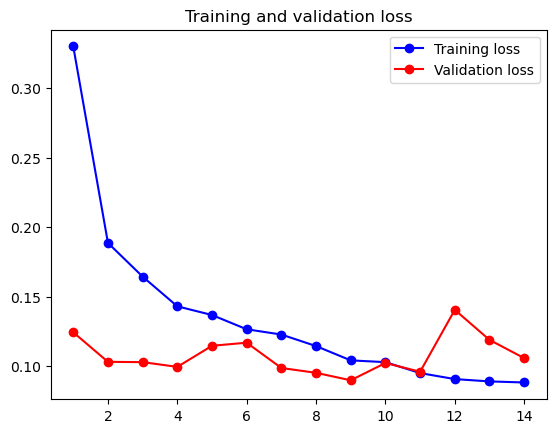

In [15]:
# InceptionV3 fine-tuning the last layer (dropout + data augmentation)
# Instantiating the InceptionV3 convolutional base
conv_base = keras.applications.InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

checkpoint_filename = "/InceptionV3_finetuning_dropout_da.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "fn_lr": 1e-5, # We’ll use a very low learning rate when fine-tuning our model.
    "optimizer": optimizers.Adam,

    "n_fine_tuned_layers": 4,  # apart from the Denses, starting from the bottom of the network

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(conv_base, train_dataset, val_dataset, hyperparameters)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_6 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_6 (Flatten)         (None, 32768)             0         
                                                                 
 dense_15 (Dense)            (None, 1024)              33555456  
                                                                 
 dropout_7 (Dropout)         (None, 1024)              0         
                                                                 
 dense_16 (Dense)            (None, 5)                 5125

379/379 [==============================] - 27s 63ms/step - loss: 0.3280 - accuracy: 0.8855 - f1_score: 0.8856 - precision_9: 0.9012 - recall_9: 0.8738 - val_loss: 0.1609 - val_accuracy: 0.9421 - val_f1_score: 0.9428 - val_precision_9: 0.9518 - val_recall_9: 0.9384
Epoch 2/50
379/379 [==============================] - 23s 60ms/step - loss: 0.1852 - accuracy: 0.9307 - f1_score: 0.9309 - precision_9: 0.9379 - recall_9: 0.9245 - val_loss: 0.1165 - val_accuracy: 0.9592 - val_f1_score: 0.9598 - val_precision_9: 0.9626 - val_recall_9: 0.9555
Epoch 3/50
379/379 [==============================] - 24s 61ms/step - loss: 0.1612 - accuracy: 0.9390 - f1_score: 0.9391 - precision_9: 0.9447 - recall_9: 0.9341 - val_loss: 0.1060 - val_accuracy: 0.9644 - val_f1_score: 0.9649 - val_precision_9: 0.9708 - val_recall_9: 0.9621
Epoch 4/50
379/379 [==============================] - 23s 60ms/step - loss: 0.1480 - accuracy: 0.9446 - f1_score: 0.9447 - precision_9: 0.9517 - recall_9: 0.9392 - val_loss: 0.0990 - 

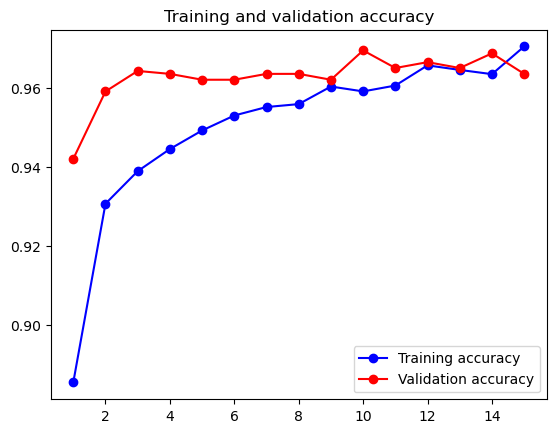

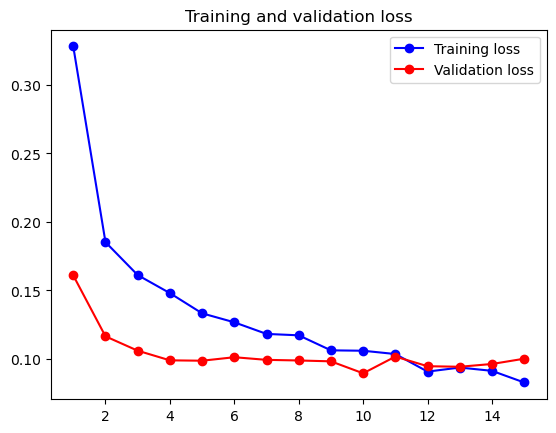

In [16]:
# InceptionV3 fine-tuning the two last layers (dropout + data augmentation)
# Instantiating the InceptionV3 convolutional base
conv_base = keras.applications.InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

checkpoint_filename = "/InceptionV3_finetuning2_dropout_da.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "fn_lr": 1e-5, # We’ll use a very low learning rate when fine-tuning our model.
    "optimizer": optimizers.Adam,

    "n_fine_tuned_layers": 8,  # apart from the Denses, starting from the bottom of the network

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(conv_base, train_dataset, val_dataset, hyperparameters)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 inception_resnet_v2 (Funct  (None, 4, 4, 1536)        54336736  
 ional)                                                          
                                                                 
 flatten_7 (Flatten)         (None, 24576)             0         
                                                                 
 dense_17 (Dense)            (None, 1024)              25166848  
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                          

379/379 [==============================] - 59s 127ms/step - loss: 0.2591 - accuracy: 0.9026 - f1_score: 0.9026 - precision_10: 0.9310 - recall_10: 0.8791 - val_loss: 0.1030 - val_accuracy: 0.9651 - val_f1_score: 0.9656 - val_precision_10: 0.9743 - val_recall_10: 0.9577
Epoch 2/50
379/379 [==============================] - 43s 111ms/step - loss: 0.1645 - accuracy: 0.9395 - f1_score: 0.9395 - precision_10: 0.9496 - recall_10: 0.9300 - val_loss: 0.0989 - val_accuracy: 0.9644 - val_f1_score: 0.9650 - val_precision_10: 0.9722 - val_recall_10: 0.9599
Epoch 3/50
379/379 [==============================] - 44s 114ms/step - loss: 0.1446 - accuracy: 0.9481 - f1_score: 0.9482 - precision_10: 0.9549 - recall_10: 0.9408 - val_loss: 0.0956 - val_accuracy: 0.9651 - val_f1_score: 0.9657 - val_precision_10: 0.9686 - val_recall_10: 0.9621
Epoch 4/50
379/379 [==============================] - 43s 111ms/step - loss: 0.1238 - accuracy: 0.9532 - f1_score: 0.9532 - precision_10: 0.9601 - recall_10: 0.9471 - v

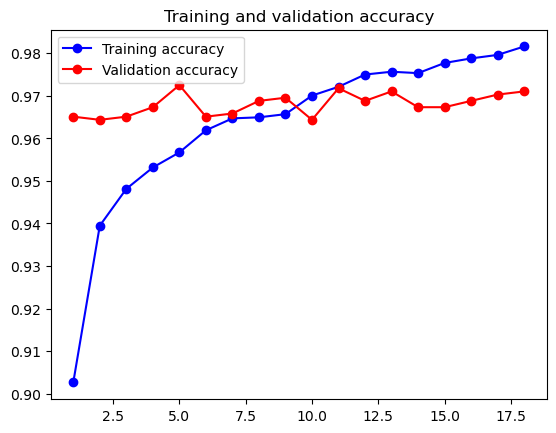

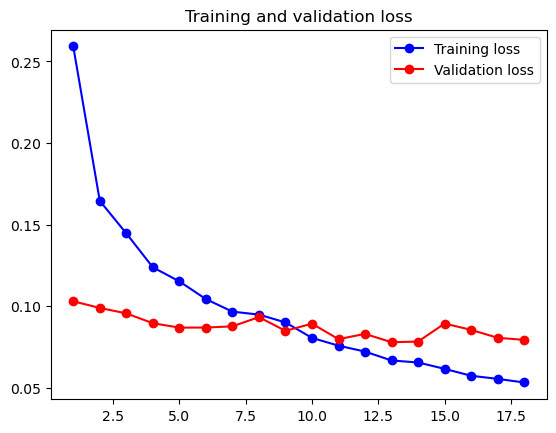

In [17]:
# InceptionResNetV2 fine-tuning the last layer (dropout + data augmentation)
# Instantiating the InceptionResNetV2 convolutional base
conv_base = keras.applications.InceptionResNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

checkpoint_filename = "/InceptionResNetV2_finetuning_dropout_da.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "fn_lr": 1e-5, # We’ll use a very low learning rate when fine-tuning our model.
    "optimizer": optimizers.Adam,

    "n_fine_tuned_layers": 4,  # apart from the Denses, starting from the bottom of the network

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(conv_base, train_dataset, val_dataset, hyperparameters)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 inception_resnet_v2 (Funct  (None, 4, 4, 1536)        54336736  
 ional)                                                          
                                                                 
 flatten_3 (Flatten)         (None, 24576)             0         
                                                                 
 dense_7 (Dense)             (None, 1024)              25166848  
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                           

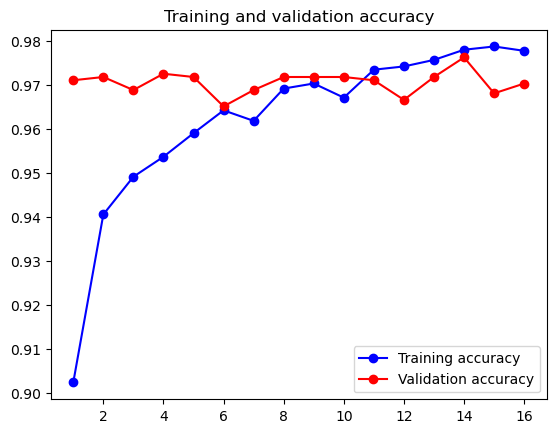

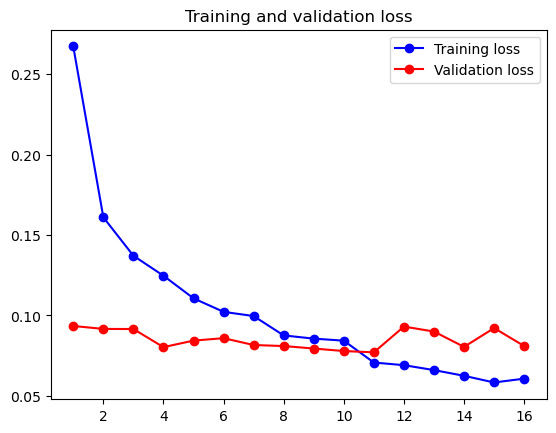

In [14]:
# InceptionResNetV2 fine-tuning the two last layers (dropout + data augmentation)
# Instantiating the InceptionResNetV2 convolutional base
conv_base = keras.applications.InceptionResNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

checkpoint_filename = "/InceptionResNetV2_finetuning2_dropout_da.keras"
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "fn_lr": 1e-5, # We’ll use a very low learning rate when fine-tuning our model.
    "optimizer": optimizers.Adam,

    "n_fine_tuned_layers": 8,  # apart from the Denses, starting from the bottom of the network

    "dropout":True,
    "data_augmentation": keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    ),
    "lr_scheduler": None,
    "early_stop": keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": keras.callbacks.ModelCheckpoint(OUT_MODELS_FOLDER + checkpoint_filename, 'val_loss', save_best_only=True)
}

model, history = execute_pipeline(conv_base, train_dataset, val_dataset, hyperparameters)

## 4. Discussion and results comparison.

Along this notebook step-by-step explanations were provided of the followed steps during the project. To conclude we will discuss the most relevant steps and compare the performance of the best model obtained for each approach.

Multiple different configurations have been tested. First of all, we have trained an arbitrary baseline model as a starting point to check whether CNNs are suitable for the problem to handle, having only the 2 blocks of convolution and max-pooling layers, plus the final classifier with denses layers.

As expected, CNN were a good option for image classification since they initially provided a quite good accuracy without receiving a task tuning.

Our **first** approximation consisted in creating a CNN architecture from scratch, so we did several experiments to find an architecture suitable for our problem following tuning process and tracking the validation accuracy. We concluded that the best architecture was {'input_units': 64, 'kernel_size': 3, 'n_layers': 3, 'n_conv': 1, 'n_connections': 3, 'n_nodes': 128} and we proceeded to train this baseline model. However, it started to overfit very soon. Concretely in epoch 5, point from which the validation loss started to increase, while the training loss kept decreasing.

The overall metrics were quite acceptable, with an accuracy of 83.60% in validation. Observing that the training loss and training accuracy was still improving, we tried to regularize the network in order to let the validation performance to be improved as well. First of all, we tried using batch normalization layers after the convolutional layers to make the training faster and more stable. However, it did not seem to reduce overfitting and even affected the loss curve making the training much more inestable. On the other hand, using dropout and data normalization seemed to affect positively the training, specially the former one which achieved to delay the overfitting emergence to the epoch 7 and obtaining a validation accuracy of ~0.82, slighly lower than the baseline model.

Regarding weight regularization, L1 regularization makes the model completely unable to learn the patterns from the dataset, returning a validacion_accuracy of 0.2 (random classification since there are 5 classes). L1 regularization is generally considered to generate models that are simple and interpretable but not capable of learning complex patterns, which highlights the necesity of learning complex patterns in our dataset. The same occurs when combined with L2.

However, applying L2 regularization we achieved to stabilize the training delaying the overfitting emergence until epoch 12 and obtaining a validation accuracy of 0.8159. We tryied then combining some of the techniques which seemed to deal with the overfitting problem, such as Dropout with Data augmentation in which the model updated the weights too drastically causing a inestability in the training and which make us aware of the importance of the learning rate parameter.

Reducing it to 0.0005 allowed to stabilize the training and obtain a ~0.86 validation accuracy avoiding early overfitting problems as well. Having as a goal to reach the 90% in validation accuracy, we decided to repeat the previous process adding a learning rate scheduler to progressively reduce the learning rate value (**Learning rate decay**) and then test adding L2 regularization which provided good results in the previous experiments. 

The combination of dropout with data augmentation and learning rate scheduler provided the **best results for the scratch model** with a validation accuracy around 0.88. However adding L2 regularization, though it did not affect to the training stability, reduced considerably the classification performance.

Our **second** approximation consisted in repeating the previous experiments but with a different baseline architecture (random) just to detect whether the architecture tuning process is actually helpful for DL trainings. We obtained similar problems to the first architecture and at the end we were not able to surpass the previous performance results having in general much lower metrics and highlighting the **importance of the initial architecture tuning process** for finding the architecture most suitable for our problem.

Our **third** approximation consisted in testing with more complex architectures (not pretrained), concretely VGG16, VGG19, Inception, InceptionResNetV2, Xception and Residual. The training using VGG16 and VGG19 was not succesfull and we attached this problem to the huge complexity of these architectures with respect to our small dataset. They are composed by a large number of parameters and they were originally trained on the ImageNet dataset, which contains millions of images across thousands of categories. A small dataset does not provide enough diverse examples for the model to learn robust features and generalize well to unseen data.

For the rest of the models in general the results were quite similar to the ones obtained when training the model from scratch (with a validation accuracy near ~0.8). However, Xception model achieved to reach the 0.9 of validation accuracy. Note that for Inception and Residual networks we had to repeat the training because of a too high learning rate, similar as a problem occured when training the architecture from scratch.

Our **fourth** approximation consisted in creating a wide model using Depthwise separable convolutions. As always, we first trained the baseline model and then we applyied regularization techniques. The baseline networks started to overfit in epoch 11 so we deciced to try the model adding dropout and data augmentation since they previously demonstrated more appropiate evolution of the curves. Both techniques improved considerable the results (from 0.8 to 0.9 of validation accuracy) and adjusted training and validation curves almost perfectly.

Our **fifth** approximation consisted in applying transfer learning for three pre-trained models: **VGG16, VGG19** and an additional experiment using the **best convolutional model trained from scratch** in the previous section. We followed two different transfer learning paradigms trying to maximize the performance of those models: feature extraction and fine-tuning.

The VGG16 baseline model was a really good starting point since it provides very good results (validation accuracy: 0.9117) overcoming our previous model defined from scratch. However the training is stopped soon because the network starts to overfit in epoch 3. Thus we tryied to reduce the overfitting problem using **dropout** and **data augmentation**. Testing this selected regularized network, the overfitting problem had been highly reduced since the validation loss kept almost horizontal. Nevertheless, we could observe some peaks derived from a high learning rate value, so we used again the learning rate scheduler to reduce this problem and train again reaching a validation accuracy of 0.9198. The rest of the models provided similar results being InceptionResNetV2 the one which achieves the best validation results (~0.97).

Then, we tested the fine-tuning approach carrying out experiments training 1 and 2 convolutional blocks. Using the baseline model without regularization we could see good validation results, reaching validation accuracies of ~0.94. However when we applyied regularization we achieved to improved the performance even more. In general fine-tuning 2 layers seemed to provide better validation results.

Regarding the experiment with the best model trained from scratch in the previous section using feature extraction. It was interesting to see that the loss curve remained constant across epochs due to the network had already learned features specific to the dataset during the initial training. However, it is always a good practice to experiment with different approaches and evaluate their performance empirically. Sometimes, even if the initial features learned during pre-training overlap with the dataset, fine-tuning certain layers or adapting the network's architecture can still lead to improvements in performance.

To end with this section we will analyze test results of the best models obtained from validation results. The following plot sets a comparison among them. 

In [16]:
def metric_comparison_plot(model_names, metric_name, val, test):
    num_models = len(val)

    # Plot the results
    plt.figure(figsize=(14, 6))
    bar_width = 0.35
    index = np.arange(num_models)

    plt.bar(index, val, bar_width, label='Validation '+metric_name)
    plt.bar(index + bar_width, test, bar_width, label='Test '+metric_name)

    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.title('Animal classification results')
    plt.xticks(index + bar_width / 2, [label.replace('_', '_\n') for label in model_names])
    plt.legend()

    plt.tight_layout()
    plt.show()

In [17]:
models = [f for f in os.listdir(OUT_MODELS_FOLDER) if f.endswith('.keras')]

47/47 [==============================] - 3s 58ms/step - loss: 0.1715 - accuracy: 0.9372 - f1_score: 0.9372 - precision: 0.9513 - recall: 0.9259


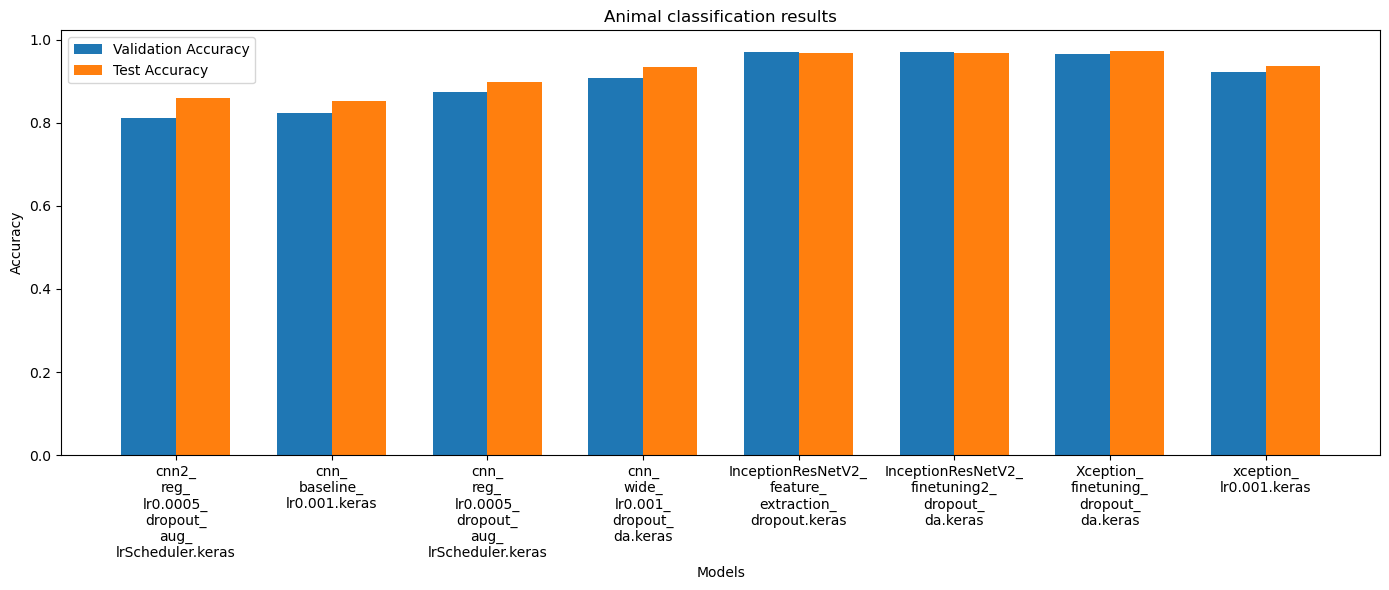

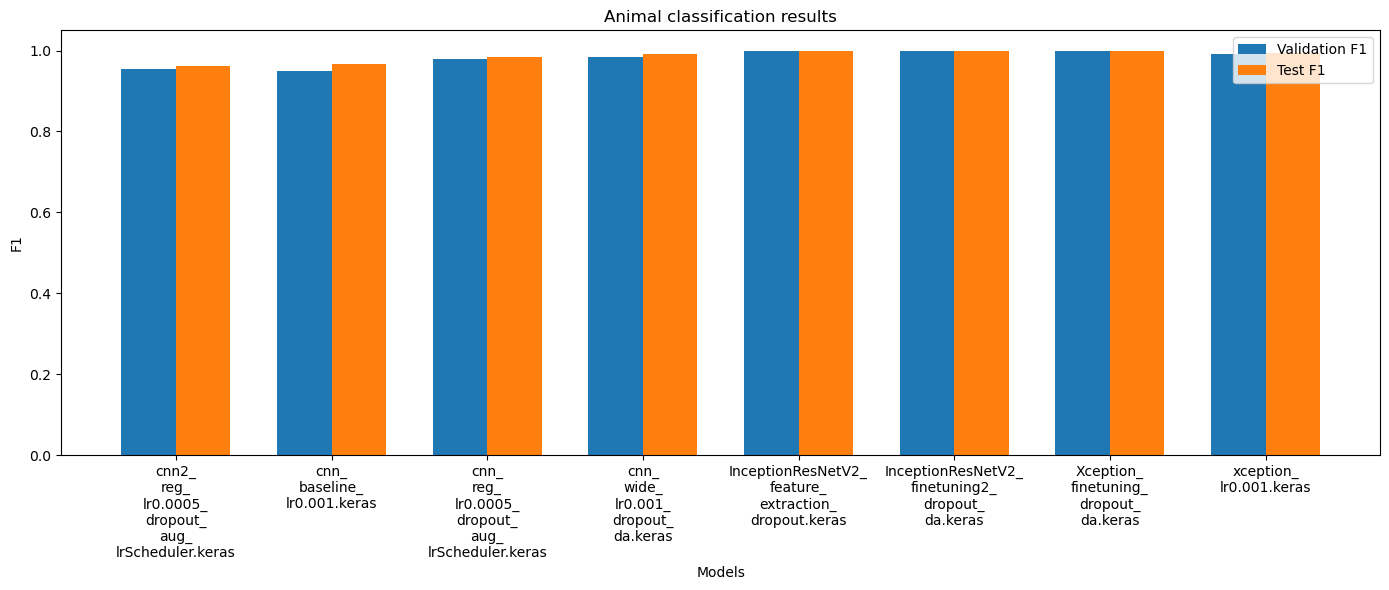

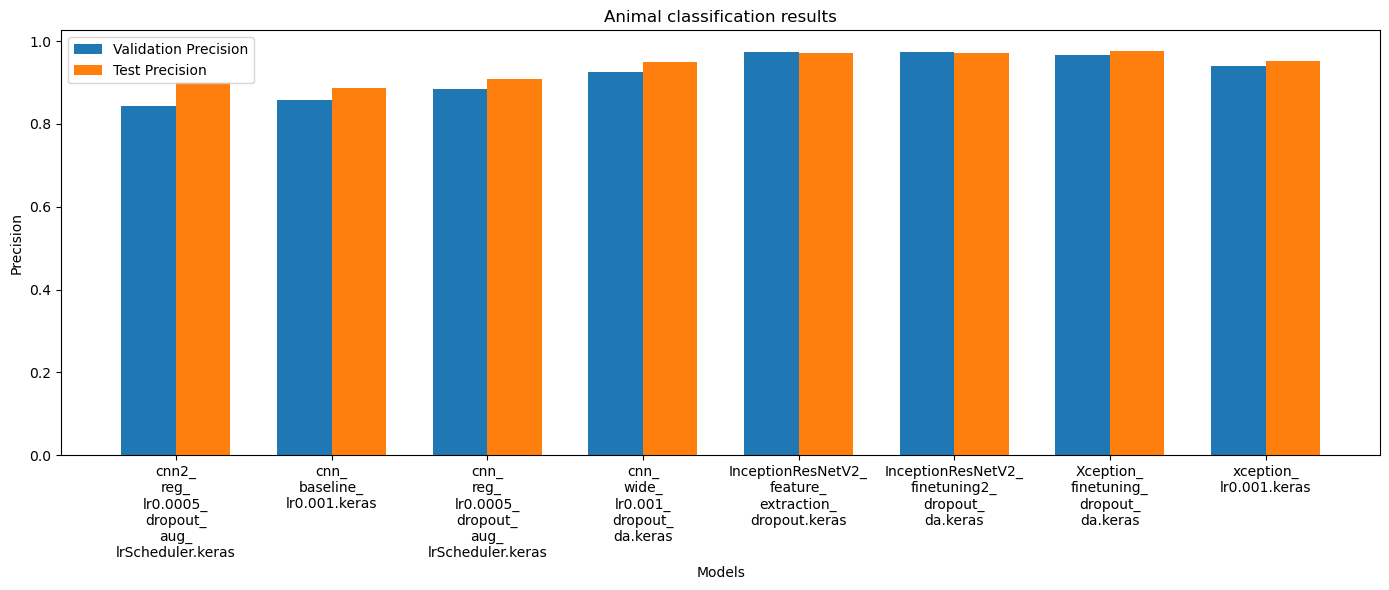

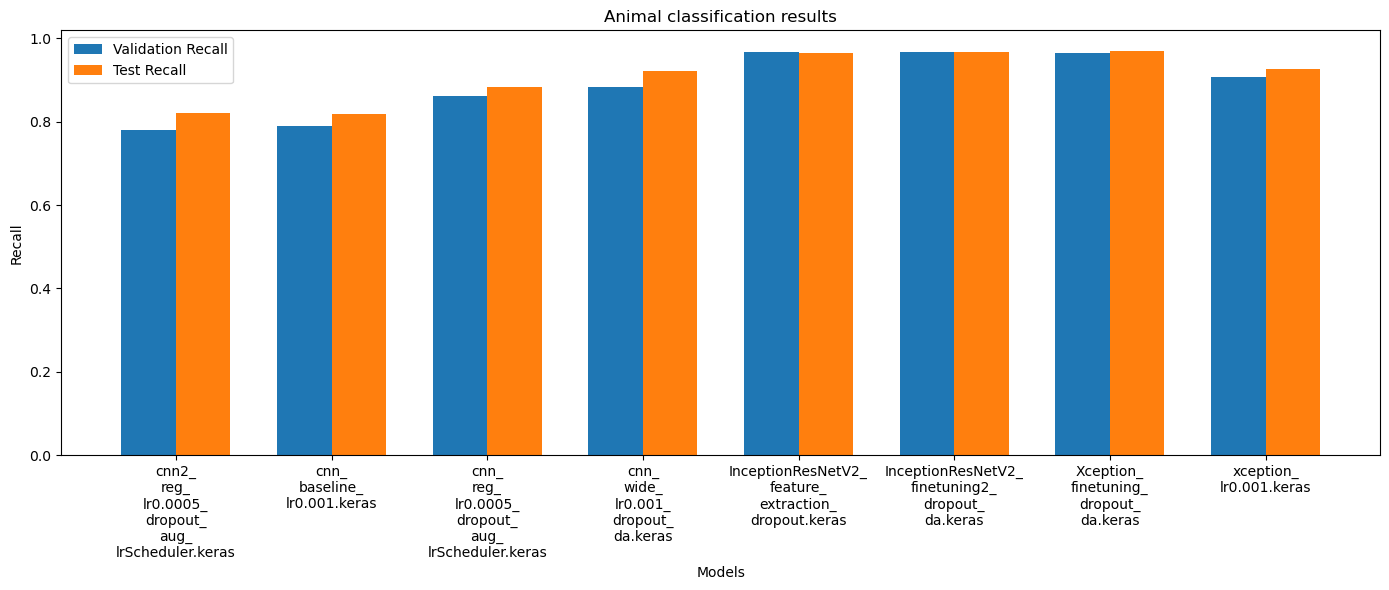

In [18]:
# Reserve memory
model_names, val_accuracies, test_accuracies, val_f1s, test_f1s, val_precisions, test_precisions, val_recalls, test_recalls = [], [], [], [], [], [], [], [], []

# Get results
for model in models:
    test_model = keras.models.load_model(OUT_MODELS_FOLDER+"/"+model)
    val_loss, val_acc, val_f1, val_precision, val_recall = test_model.evaluate(val_dataset)
    test_loss, test_acc, test_f1, test_precision, test_recall = test_model.evaluate(test_dataset)

    model_names.append(model)
    
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1[0])
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)

    test_accuracies.append(test_acc)
    test_f1s.append(test_f1[0])
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)

# Create plots
metric_comparison_plot(model_names, "Accuracy",val_accuracies,test_accuracies)
metric_comparison_plot(model_names, "F1",val_f1s,test_f1s)
metric_comparison_plot(model_names, "Precision",val_precisions,test_precisions)
metric_comparison_plot(model_names, "Recall",val_recalls,test_recalls)

In [19]:
# Create a table
table_data = [["Model", "Validation Accuracy", "Test Accuracy"]]
for i in range(len(model_names)):
    row = [models[i],val_accuracies[i],test_accuracies[i]]
    table_data.append(row)

# Print the table
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

+----------------------------------------------------+-----------------------+-----------------+
| Model                                              |   Validation Accuracy |   Test Accuracy |
+====================================================+=======================+=================+
| cnn2_reg_lr0.0005_dropout_aug_lrScheduler.keras    |              0.81069  |        0.859719 |
+----------------------------------------------------+-----------------------+-----------------+
| cnn_baseline_lr0.001.keras                         |              0.823311 |        0.852371 |
+----------------------------------------------------+-----------------------+-----------------+
| cnn_reg_lr0.0005_dropout_aug_lrScheduler.keras     |              0.873794 |        0.897796 |
+----------------------------------------------------+-----------------------+-----------------+
| cnn_wide_lr0.001_dropout_da.keras                  |              0.907944 |        0.9332   |
+-----------------------------

Below is the relationship between the previous models and the different experiments carried out to facilitate their interpretation:
- `cnn2_reg_lr0.0005_dropout_aug_lrScheduler.keras`: One random architecture from scratch trained after applying regularization
- `cnn_baseline_lr0.001.keras`: The best architecture from scratch obtained after architecture tuning
- `cnn_reg_lr0.0005_dropout_aug_lrScheduler.keras`: The best architecture from scratch obtained after architecture tuning after applying regularization
- `cnn_wide_lr0.001_dropout_da.keras`: The best wide model using Depthwise separable convolutions trained from scratch after applying regularization
- `xception_lr0.001.keras`: The best complex model trained from scratch
- `InceptionResNetV2_feature_extraction_dropout.keras`: The best complex model after applying feature extraction and regularization
- `Xception_finetuning_dropout_da.keras`: The best complex model after applying fine-tuning (1 convolutional block) and regularization
- `InceptionResNetV2_finetuning2_dropout_da.keras`: The best complex model after applying fine-tuning (2 convolutional blocks) and regularization


Here are some observations and insights from the previous results:

- **Model Performance**: The models show varying performance in terms of both validation and test accuracies. This situation could be result from a data splitting discrepancy since the validation set might be significantly harder or different from the test set. If the validation set is not representative of the test set, it can lead to differences in accuracy metrics. This can happen because the training data splitting was done randomly, and the validation set by chance contains more difficult examples.
- **Model Complexity**: More complex models like Xception seem to perform better, both in terms of validation and test accuracies, than the trained from scratch ones.
- **Depthwise separable convolutions** are really powerful mechanisms since, with significantly fewer parameters and fewer computations compared to regular convolution, obtain even higher performance results.
- **Regularization**: Models with regularization techniques such as dropout seem to perform better.
- **Transfer learning**: Since the baseline models trained from scratch gave worse results than using a pre-trained (regularized or not) model, we concluded that the transfer learning technique was **successful** for both, feature extraction and fine-tuning, and the features learned from the models during pre-training were succesfully leveraged in our classification task.
- **Fine-tuning vs. Feature Extraction**: Transfer learning approaches provided the best results along this project, reaching an impressive performance of 0.97 test accuracy (e.g `Xception_finetuning_dropout_da.keras`). Fine-tuning pre-trained models reach to improve a bit the results in test accuracy compared to feature extraction but that difference is not really high, at least in this problem. Thus we can say that **fine-tuning is better**, but not too much.
- **Learning Rate**: Learning rate values (e.g., lr0.001, lr0.0005) affect the model's performance. However, the impact varies based on the architecture and training strategy. It is important to consider this parameter value carefully.